In [1]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""





'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [2]:
# Paso 2: Carga de datos y preprocesamiento
df = pd.read_csv("adult-10p.csv")
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Codificar variable objetivo
le_income = LabelEncoder()
df["income"] = le_income.fit_transform(df["income"])  # <=50K: 0, >50K: 1

# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Variables predictoras y target
X = df_encoded.drop(columns=["income"])
y = df_encoded["income"]

# División del dataset
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Algorithm
AdaBoost              5
Bagging               5
DecisionTree          5
ERT                   5
GBM                   5
KNN                   5
LDA                   5
LogisticRegression    5
MLP                   5
NaiveBayes            5
QDA                   5
RandomForest          5
SVM                   5
XGB                   5
Name: Sensitivity, dtype: int64


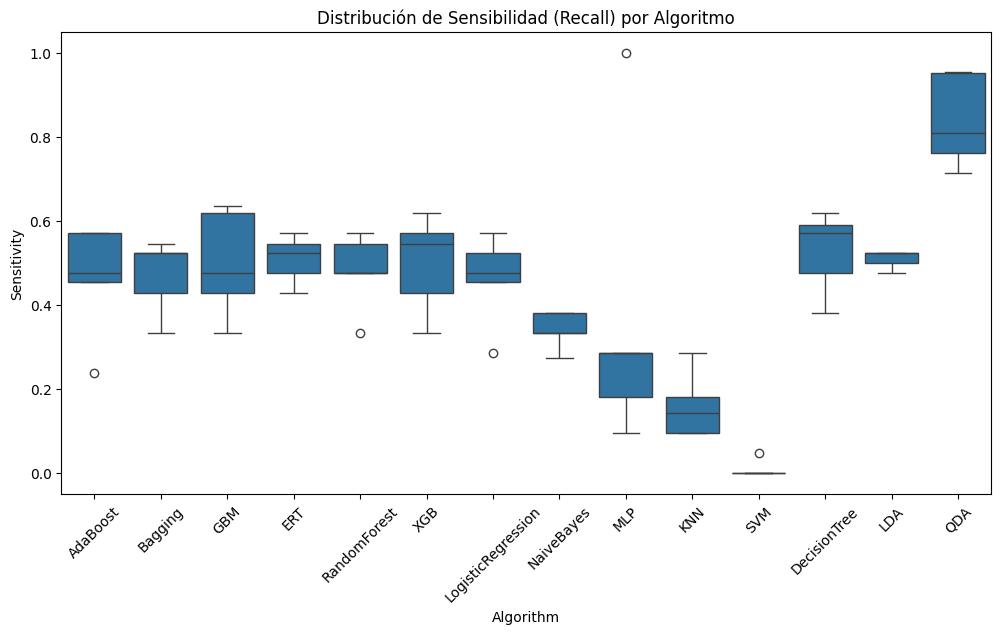

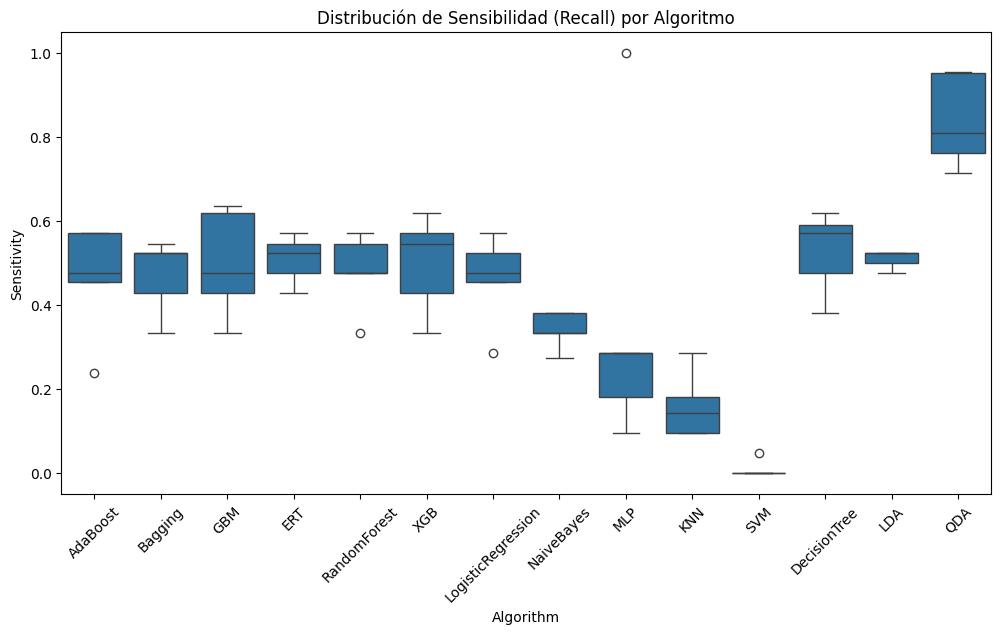

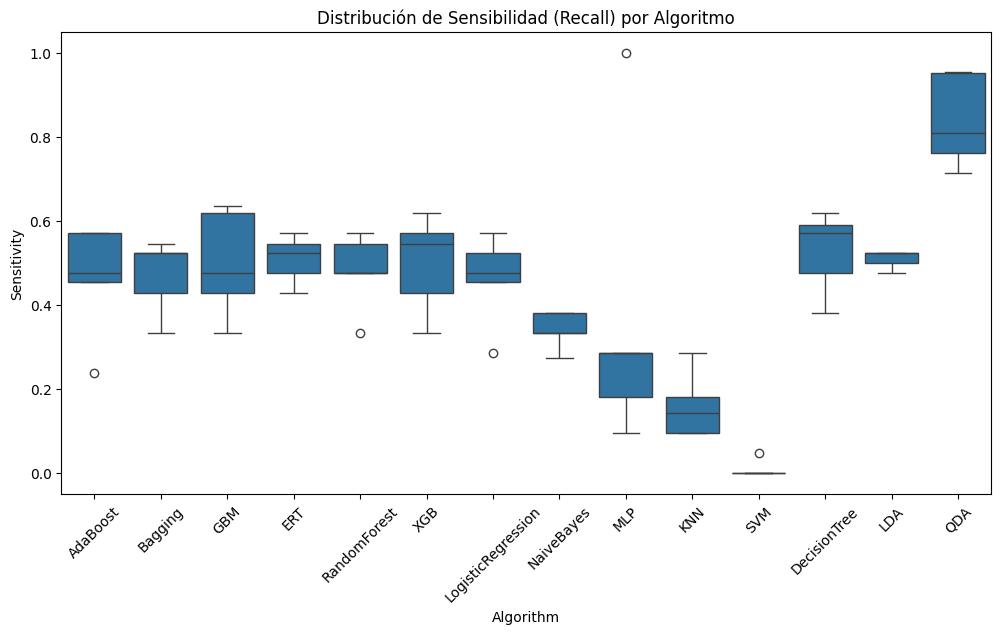

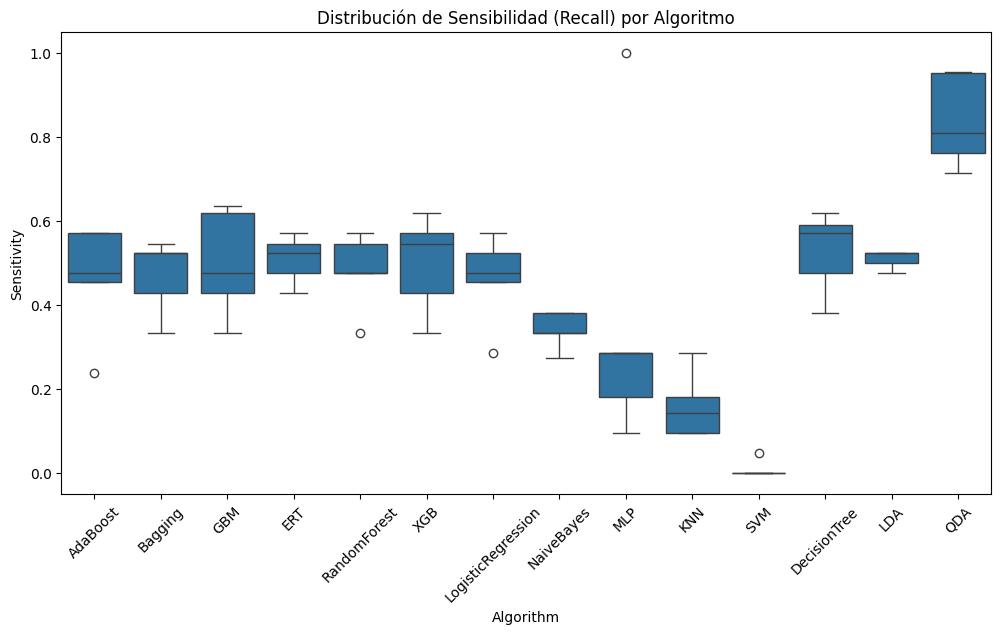

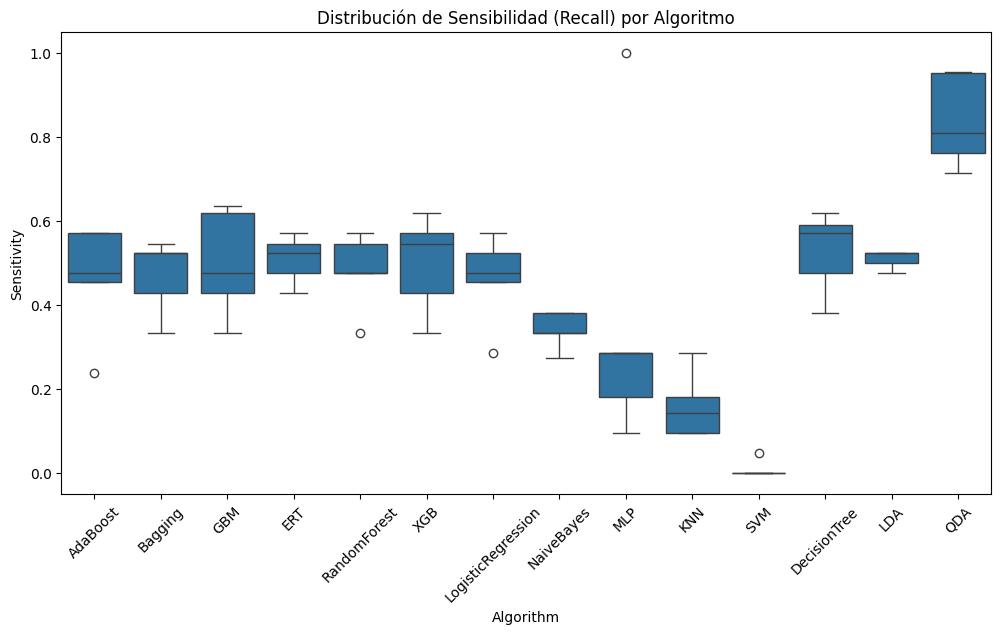

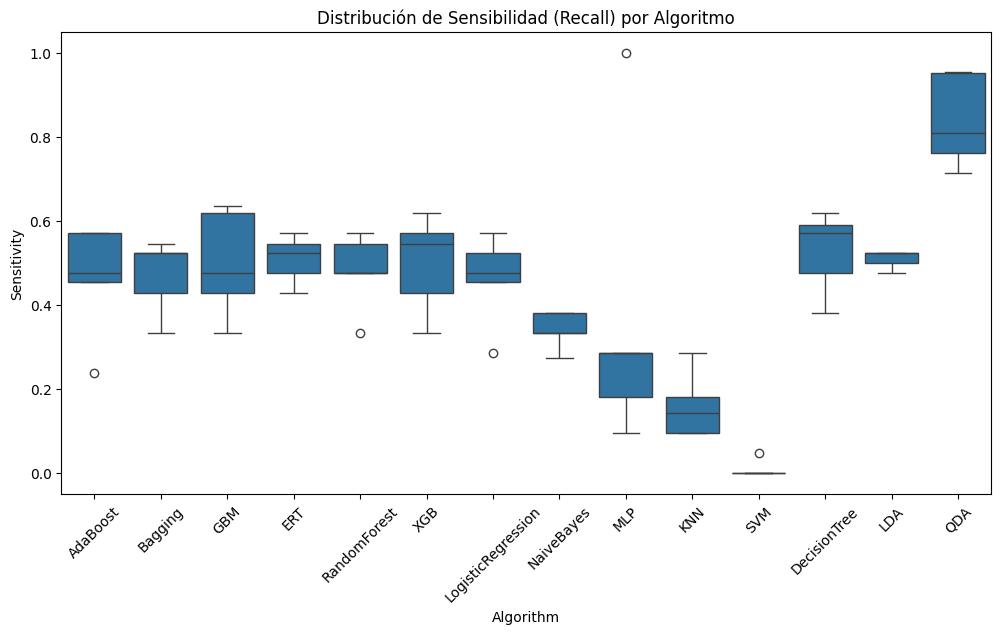

In [3]:
# Paso 4: Métricas
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)
    try:
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
    except AttributeError:
        y_pred_prob = y_pred

    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),# Nuevo
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),#nuevo
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Entrenamiento y evaluacion modelos

results = []

for model_label, model in models.items():
    # Validación cruzada manual para obtener todas las métricas
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        result = metricas(model, model_label, X_train, X_valid, y_train, y_valid)
        result['Fold'] = fold_idx
        results.append(result)

results_df = pd.DataFrame(results)



# Verificar que cada algoritmo tenga 5 valores
print(results_df.groupby("Algorithm")["Sensitivity"].count())


# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
     # Graficar boxplot
    plt.figure(figsize=(12,6))
    sns.boxplot(x="Algorithm", y="Sensitivity", data=results_df)
    plt.xticks(rotation=45)
    plt.title("Distribución de Sensibilidad (Recall) por Algoritmo")
    plt.show()
   


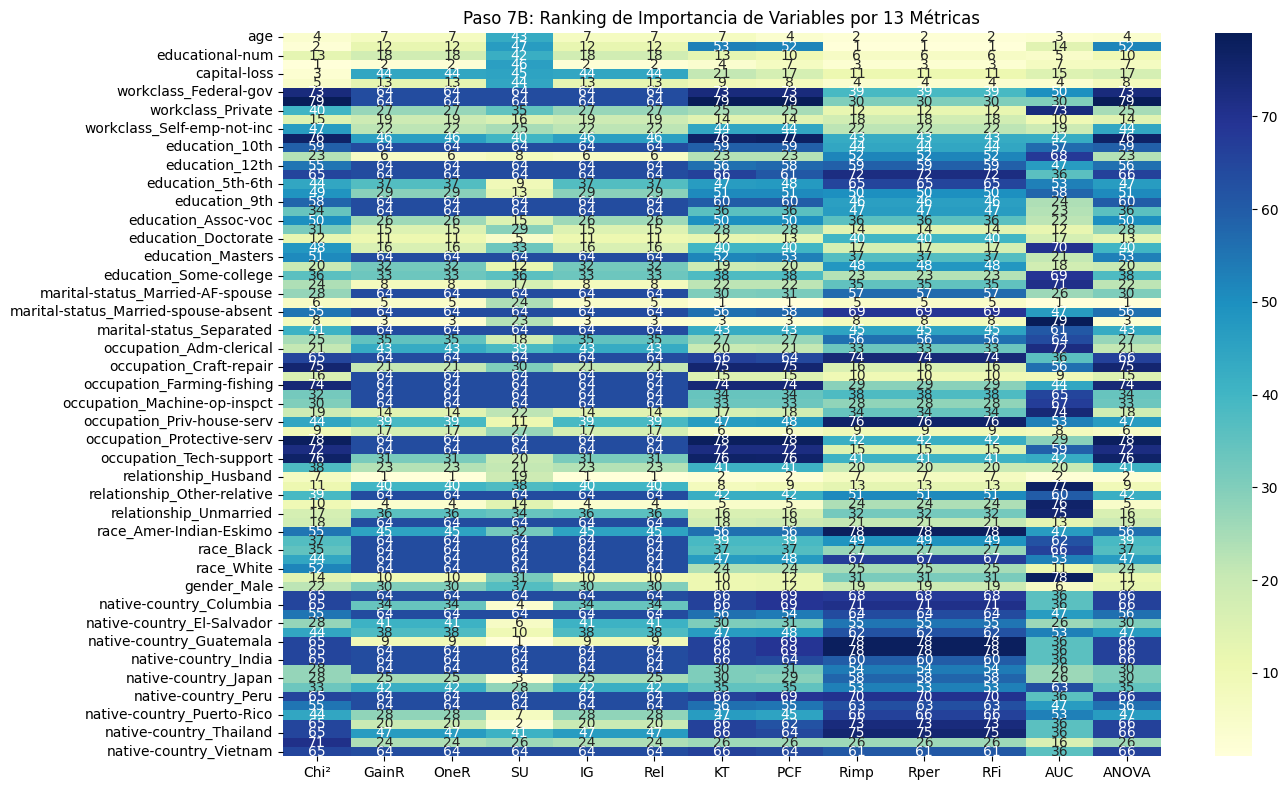

                                   Chi²  GainR  OneR    SU    IG   Rel    KT  \
relationship_Husband                7.0    1.0   1.0  19.0   1.0   1.0   2.0   
marital-status_Married-civ-spouse   6.0    5.0   5.0  24.0   5.0   5.0   1.0   
capital-gain                        1.0    2.0   2.0  46.0   2.0   2.0   4.0   
age                                 4.0    7.0   7.0  43.0   7.0   7.0   7.0   
hours-per-week                      5.0   13.0  13.0  44.0  13.0  13.0   9.0   
...                                 ...    ...   ...   ...   ...   ...   ...   
native-country_Cambodia            65.0   63.5  63.5  63.5  63.5  63.5  66.0   
education_1st-4th                  65.0   63.5  63.5  63.5  63.5  63.5  66.0   
native-country_Peru                65.0   63.5  63.5  63.5  63.5  63.5  66.0   
occupation_Armed-Forces            65.0   63.5  63.5  63.5  63.5  63.5  66.0   
native-country_Haiti               65.0   63.5  63.5  63.5  63.5  63.5  66.0   

                                    PCF

In [4]:
# Paso 7: Importancia de las características
X_imp = X.astype('float64')
y_imp = y

chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

auc_vals = [roc_auc_score(y_imp, X_imp[col]) if len(np.unique(X_imp[col])) > 1 else np.nan for col in X_imp.columns]
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Paso 7B: Ranking
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Visualización del ranking
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar top variables
print(ranking_df.sort_values("Rank"))


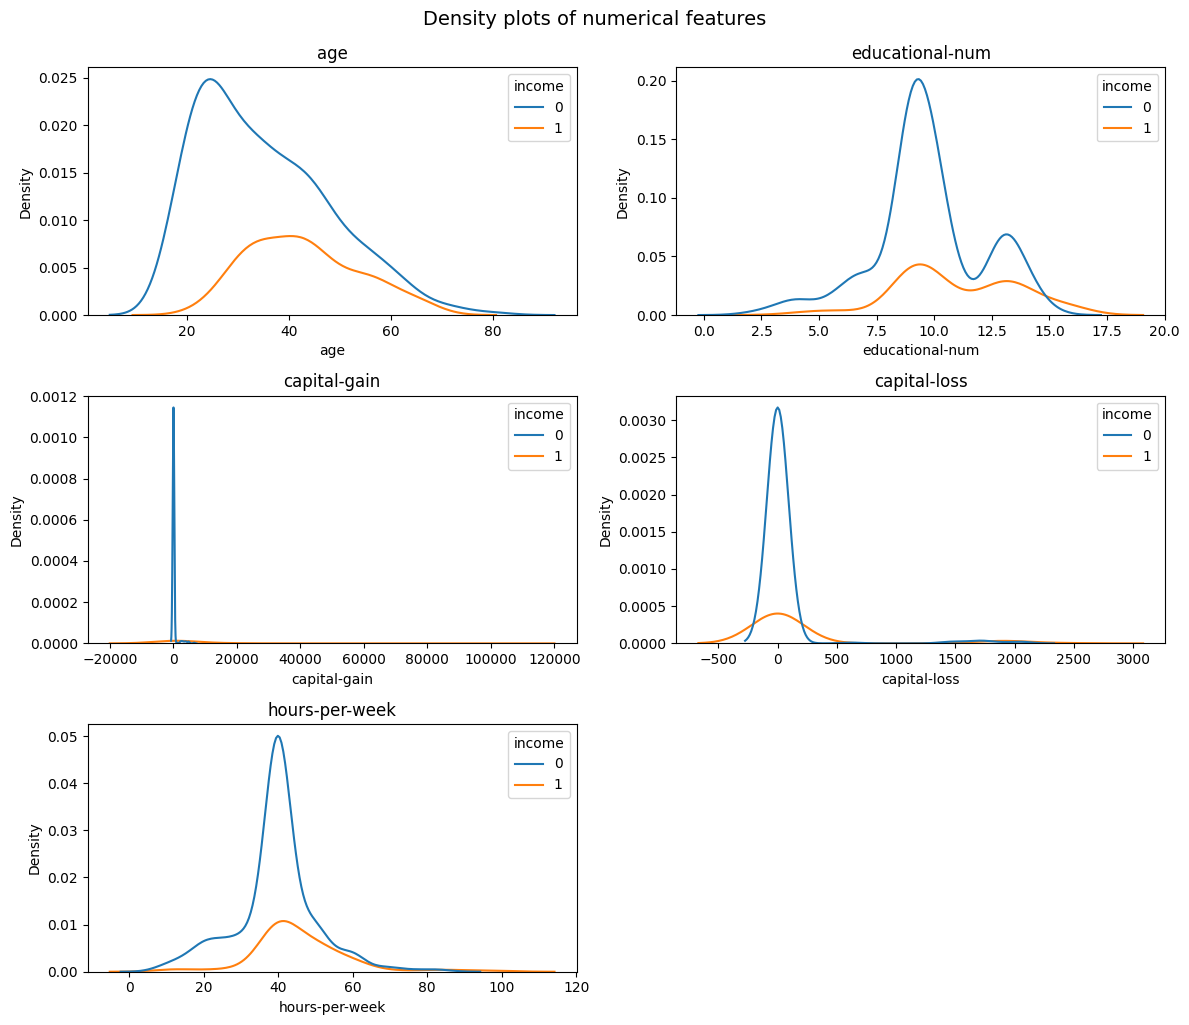

In [5]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase
numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=col, hue='income', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of numerical features", fontsize=14, y=1.02)
plt.show()



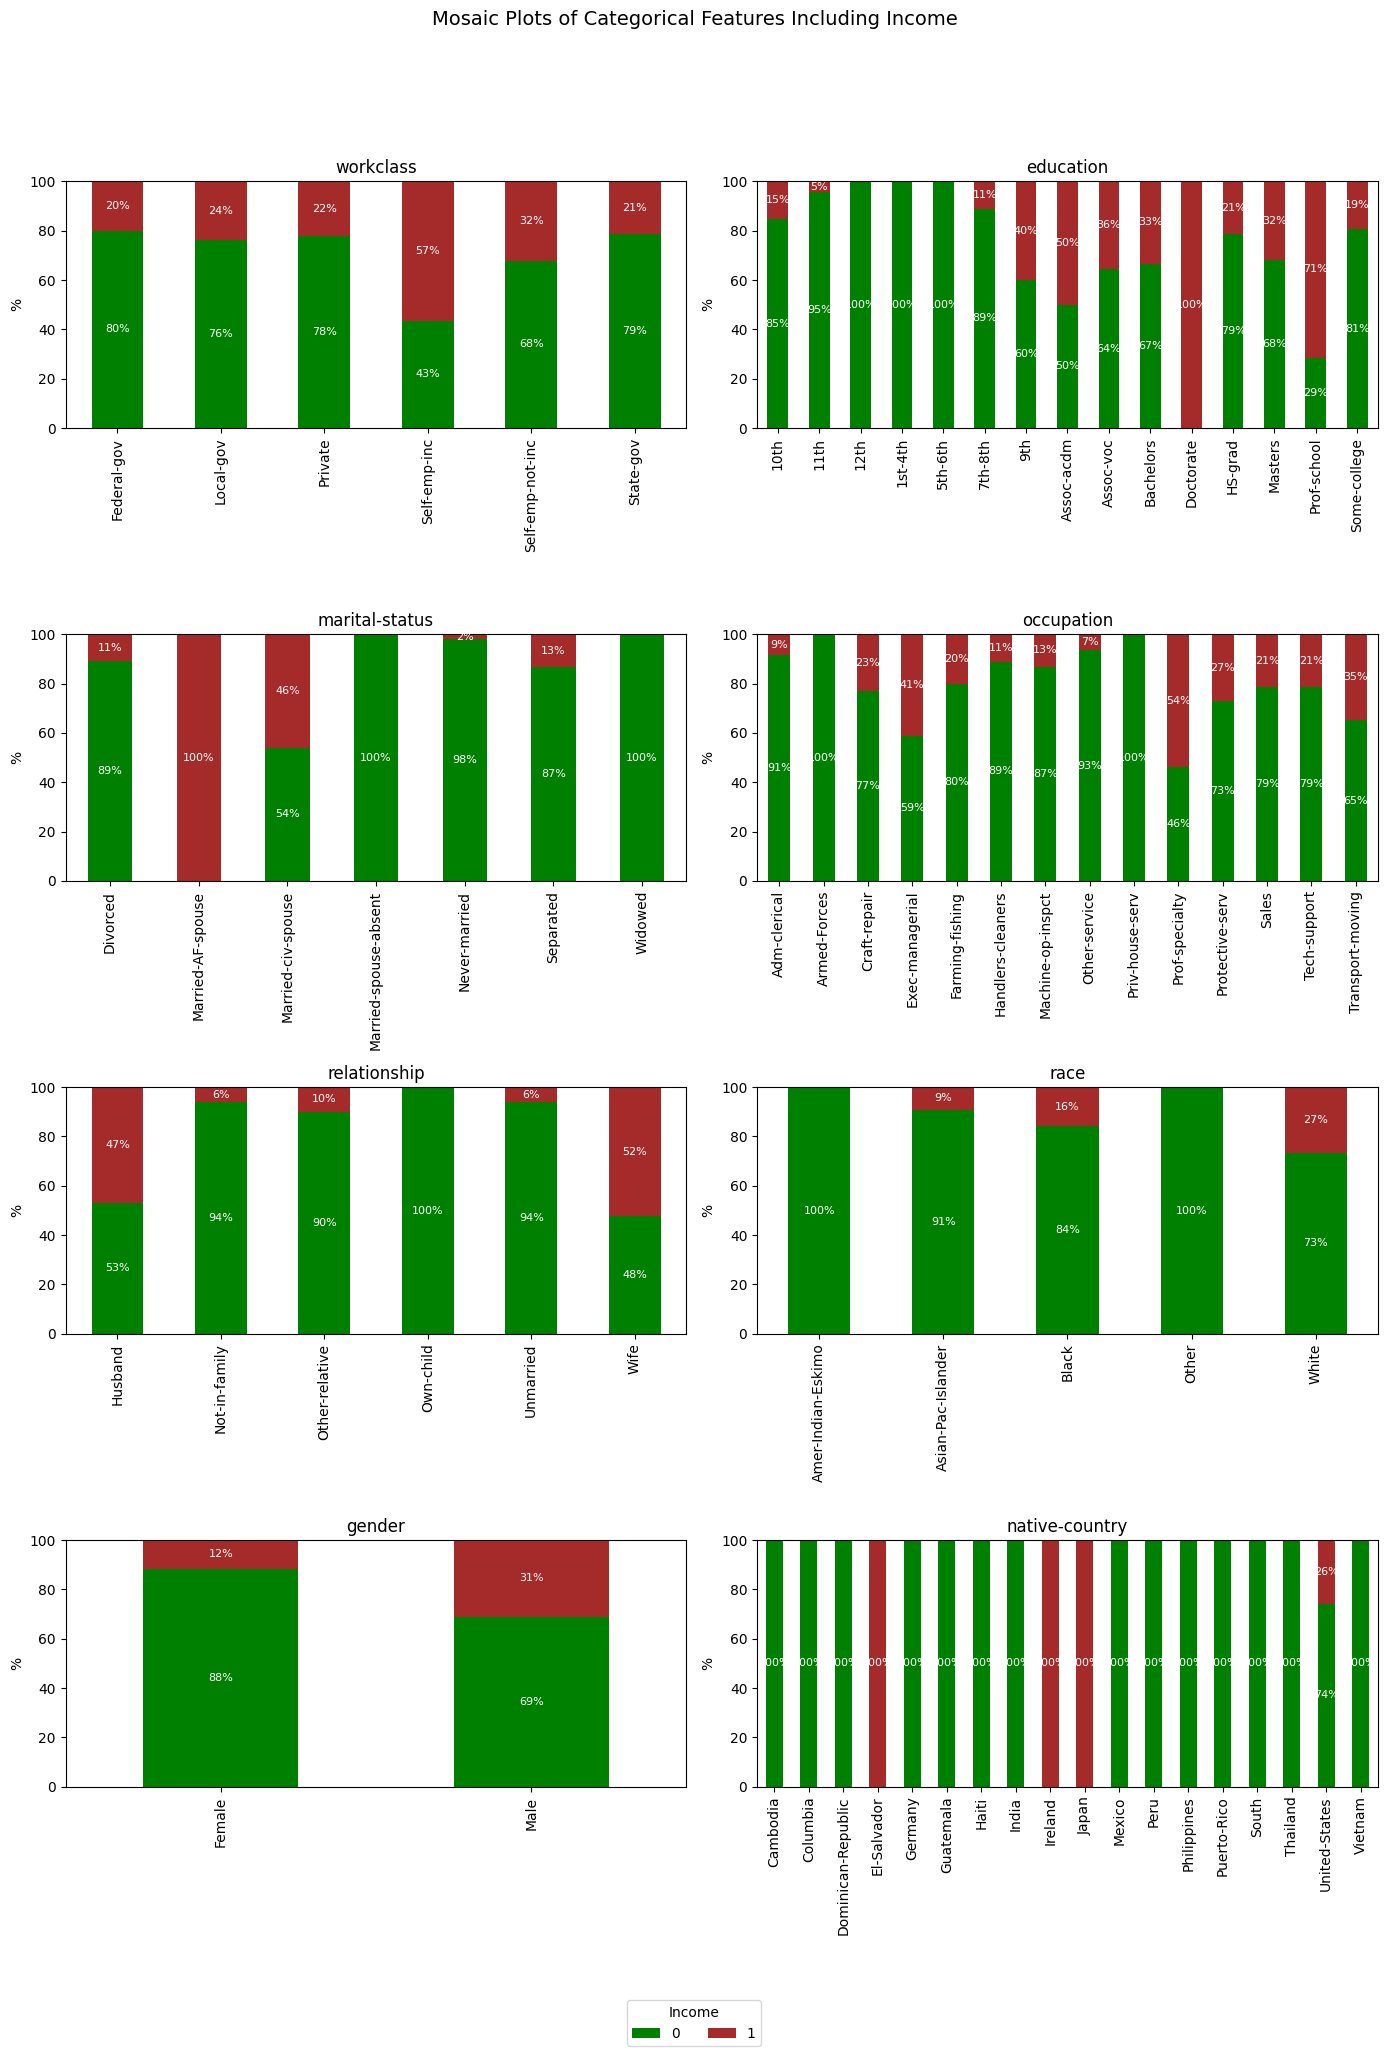

In [6]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo income
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
df_mosaic = df.copy()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    prop_df = pd.crosstab(df_mosaic[col], df_mosaic['income'], normalize='index') * 100
    prop_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'brown'], legend=False)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                    f'{height:.0f}%', ha="center", va="center", color='white', fontsize=8)
    ax.set_title(col)
    ax.set_ylabel('%')
    ax.set_xlabel('')
    ax.set_ylim(0, 100)

# Eliminar ejes sobrantes si los hay
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Categorical Features Including Income', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()



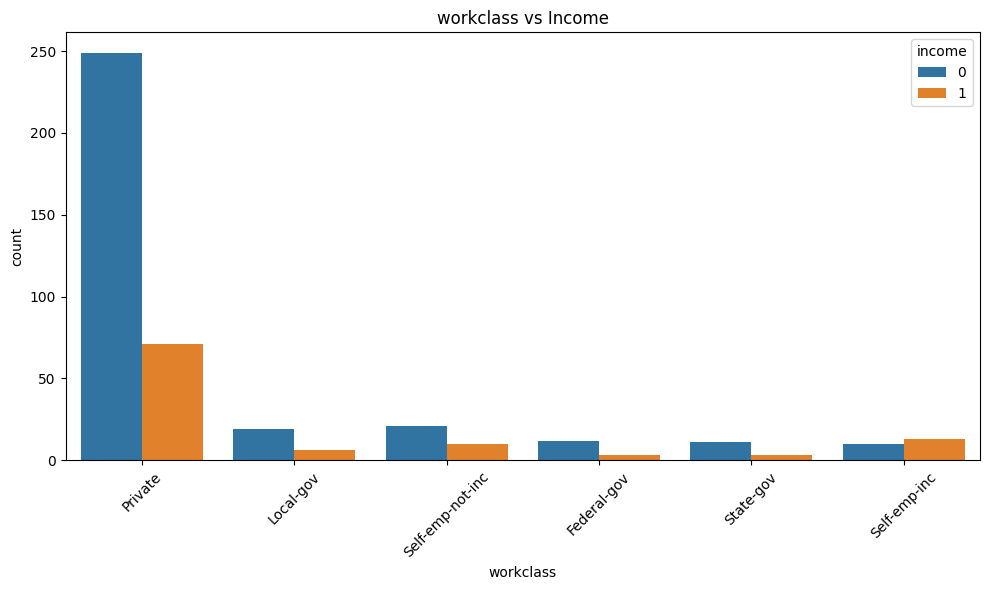

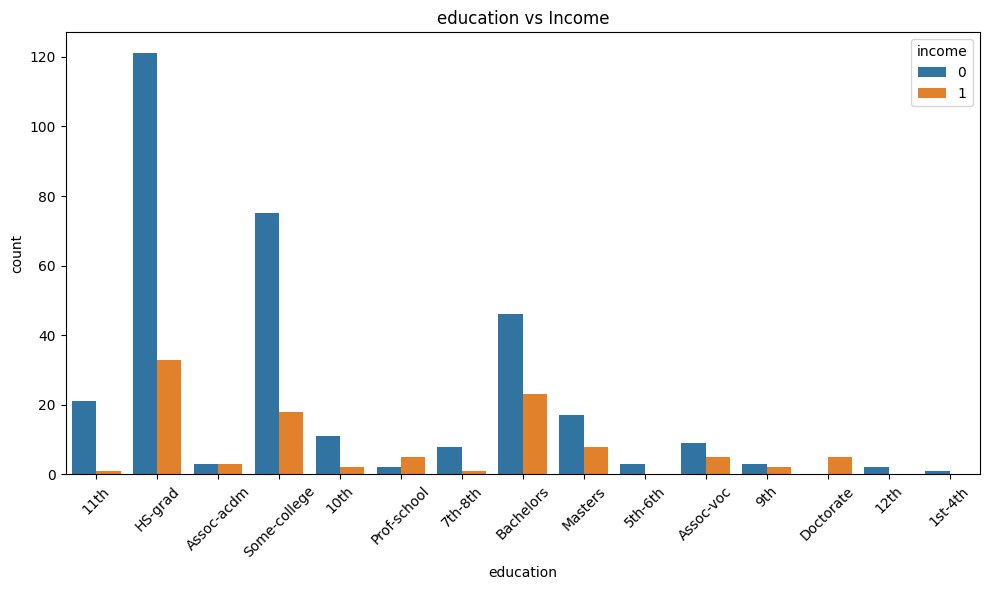

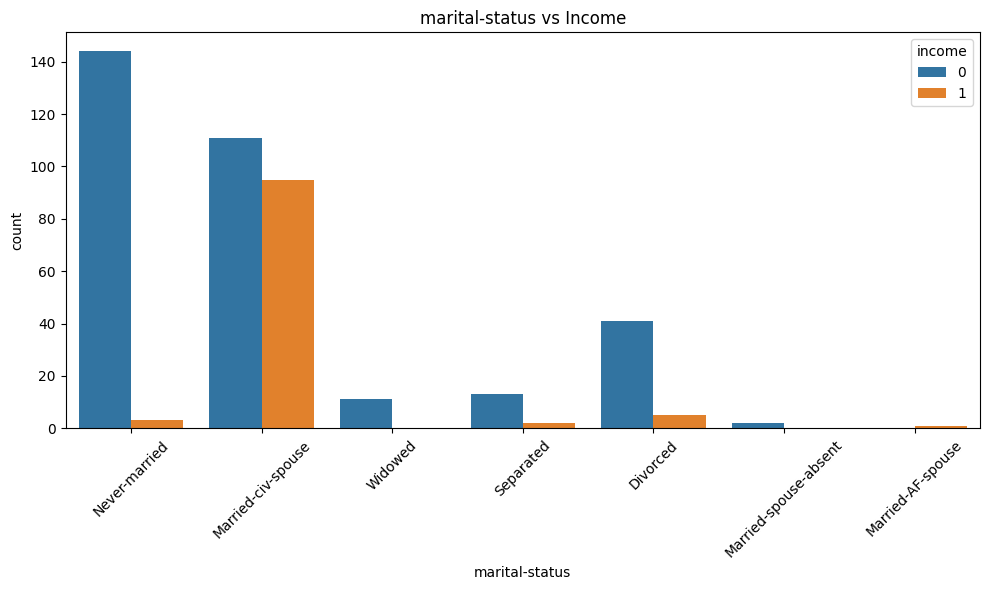

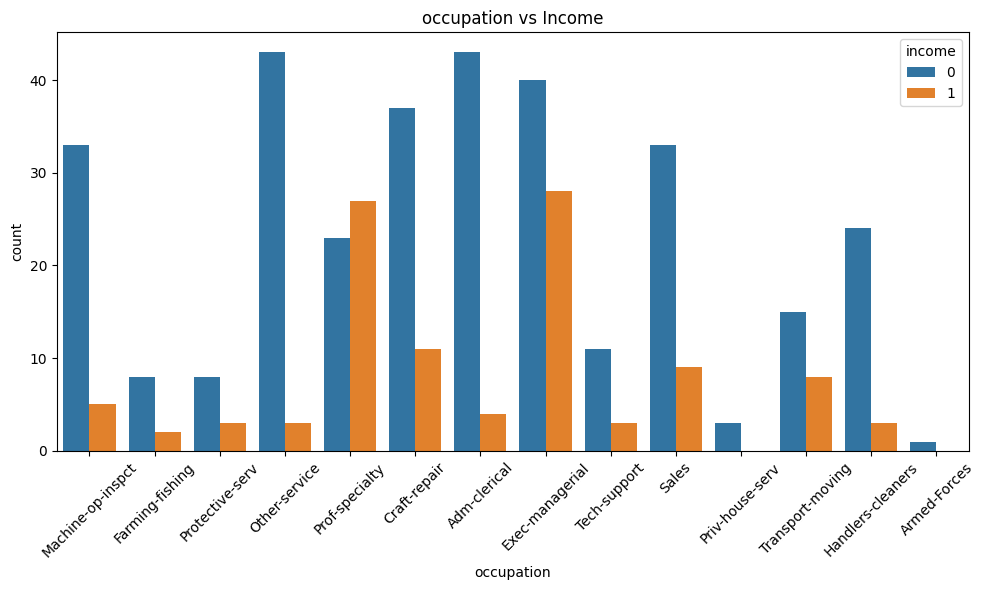

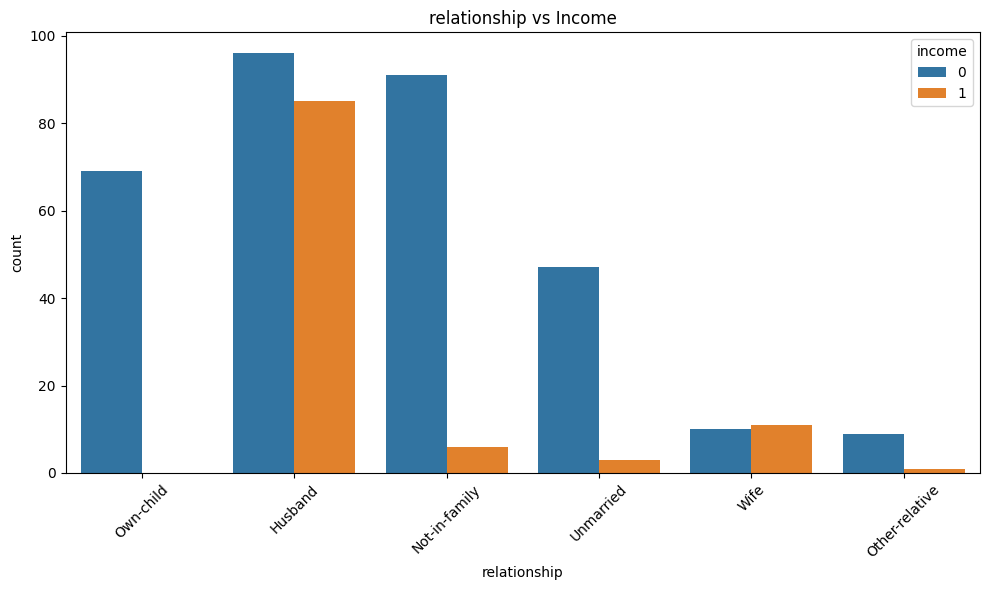

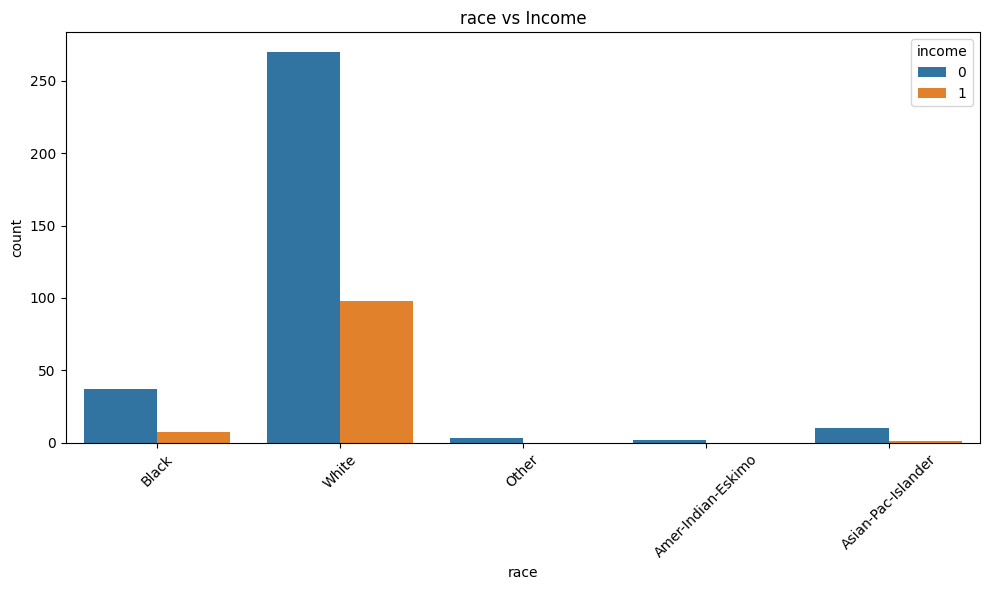

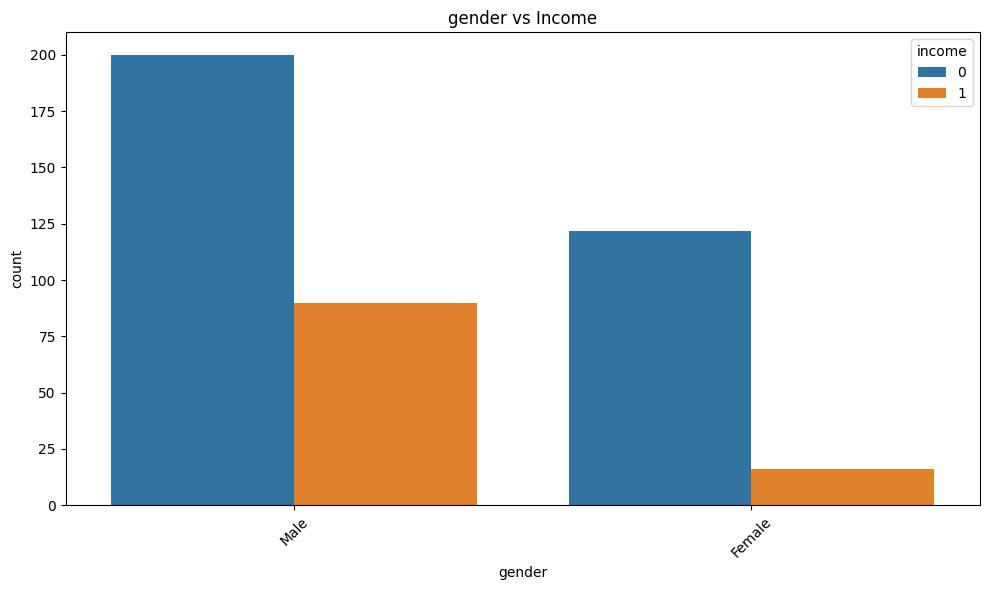

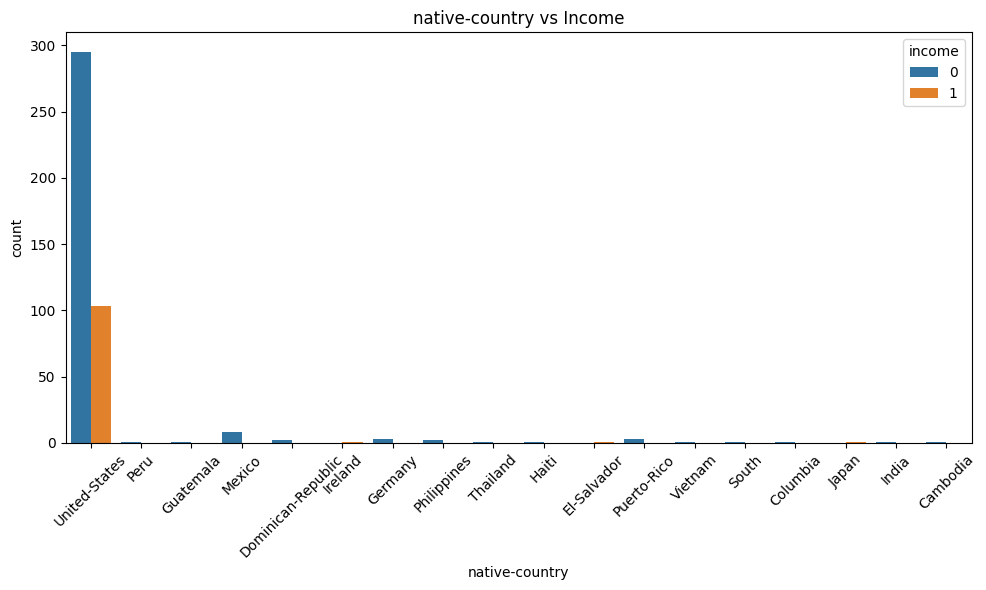

In [7]:
# Paso 8: Gráficos de variables categóricas vs income
df_vis = df.copy()
df_vis['income'] = df_vis['income'].astype(str)

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='income', data=df_vis)
    plt.title(f'{col} vs Income')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

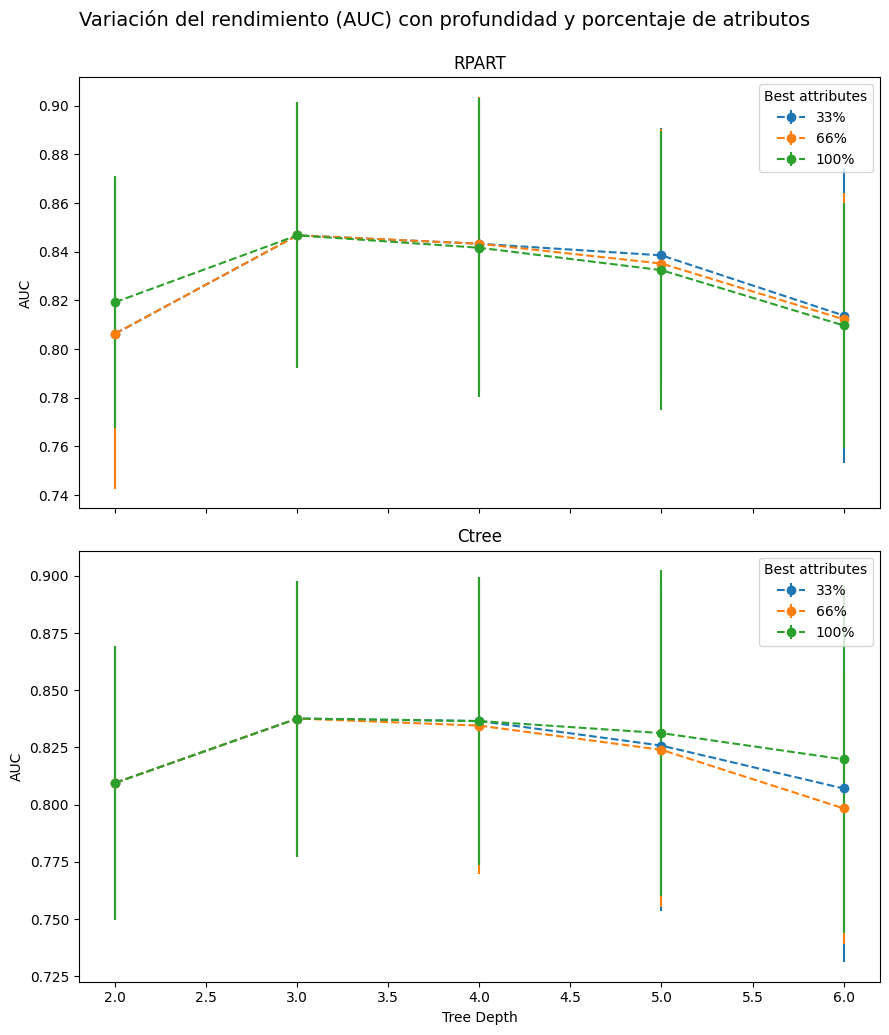

In [8]:
# Paso 8.1: Rendimiento (AUC) con profundidad y porcentaje de atributos basado en ranking
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)

top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

attribute_sets = {
    '33%': df_vis[top_33 + ['income']],
    '66%': df_vis[top_66 + ['income']],
    '100%': df_vis[top_100 + ['income']]
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, dataset in attribute_sets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    for depth in depths:
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Best attributes")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("Ctree")
axes[1].set_xlabel("Tree Depth")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Best attributes")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()


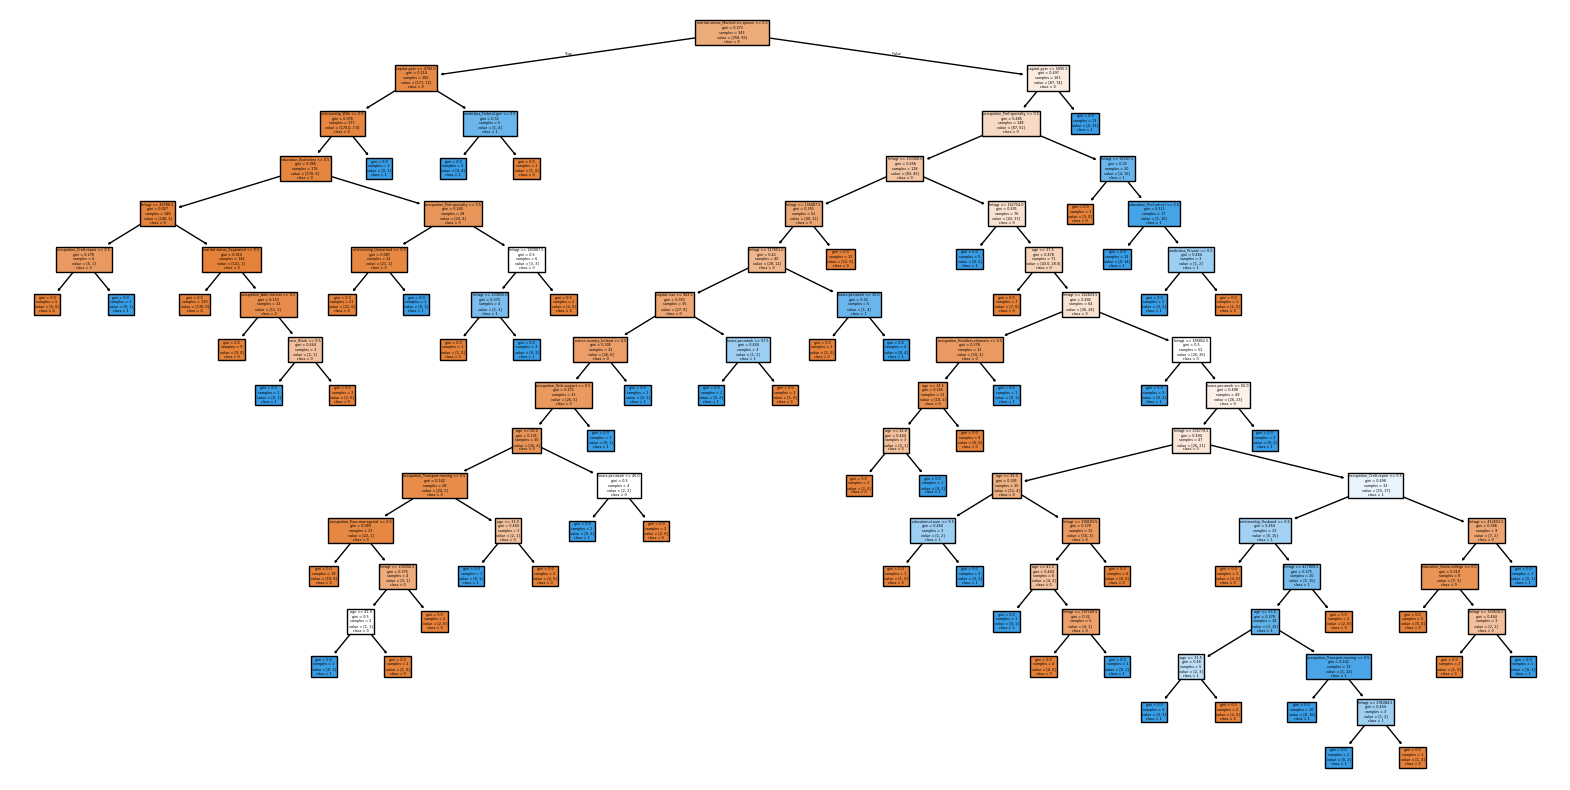

In [9]:
# Paso 9: Árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X_train.columns), class_names=['0', '1'])
plt.show()

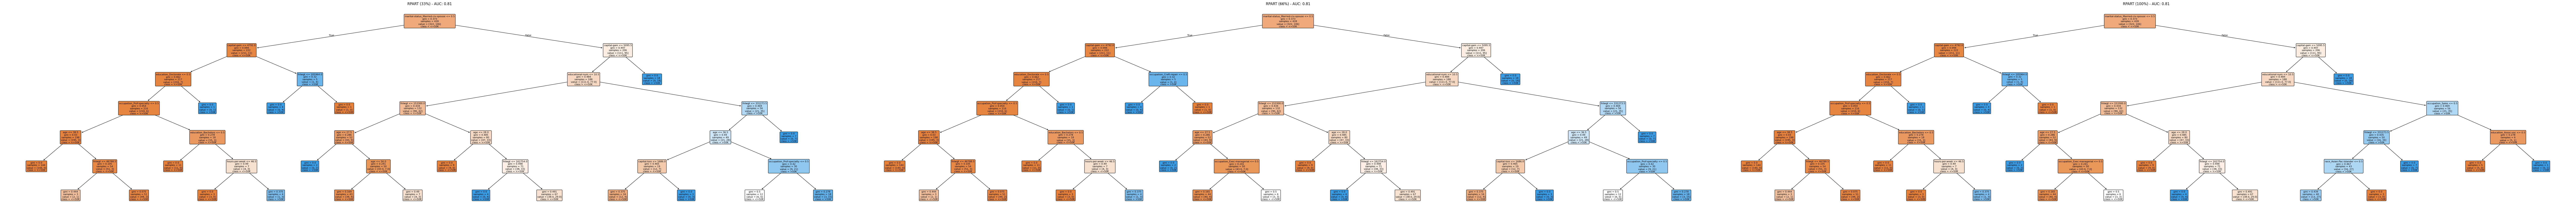

In [22]:
# Paso 9.1: Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)

top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

attribute_sets = {
    '33%': df_vis[top_33 + ['income']],
    '66%': df_vis[top_66 + ['income']],
    '100%': df_vis[top_100 + ['income']]
}

fig, axes = plt.subplots(1, 3, figsize=(120, 10))
rpart_auc_scores = {}

for ax, (name, dataset) in zip(axes, attribute_sets.items()):
    X_plot = dataset.drop('income', axis=1)
    y_plot = dataset['income']

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_plot, y_plot)

    auc = cross_val_score(model, X_plot, y_plot, cv=5, scoring='roc_auc').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_plot.columns),
        class_names=['<=50K', '>50K'],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()



In [11]:
# Paso extra: Visualización de árbol RPART con 33% de características más importantes (fuera del paso 10)
import re
from sklearn.tree import export_graphviz
import graphviz

# Paso extra: Visualización de árbol RPART con 33% de características más importantes (fuera del paso 10)
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

X_33 = df_vis[top_33]
y_33 = df_vis['income']

model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Limpiar nombres para Graphviz
def clean_column(col):
    return re.sub(r'[^a-zA-Z0-9_]', '_', col)

clean_feature_names_33 = [clean_column(col) for col in X_33.columns]

# Exportar y visualizar
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=clean_feature_names_33,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)
graph_33.view()

'tree_33.pdf'

In [12]:
# Árbol 66%
X_66 = df_vis[top_66]
y_66 = df_vis['income']
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)
clean_feature_names_66 = [clean_column(col) for col in X_66.columns]
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=clean_feature_names_66,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()

'tree_66.pdf'

In [13]:
# Árbol 100%
X_100 = df_vis[top_100]
y_100 = df_vis['income']
model_100 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_100.fit(X_100, y_100)
clean_feature_names_100 = [clean_column(col) for col in X_100.columns]
dot_data_100 = export_graphviz(
    model_100,
    out_file=None,
    feature_names=clean_feature_names_100,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_100 = graphviz.Source(dot_data_100)
graph_100.render("tree_100", format="png", cleanup=False)
graph_100.view()



'tree_100.pdf'

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

✅ df_results_all creado con columnas estandarizadas:
['Algorithm', 'attr', 'Fold', 'Accuracy', 'Precision', 'Sensitivity', 'F1', 'AUC']
  Algorithm attr  Fold  Accuracy  Precision  Sensitivity        F1       AUC
0  AdaBoost   33     1  0.930233   0.894737     0.809524  0.850000  0.969597
1  AdaBoost   33     2  0.848837   0.785714     0.523810  0.628571  0.932967
2  AdaBoost   33     3  0.744186   0.500000     0.272727  0.352941  0.800071
3  AdaBoost   33     4  0.800000   0.625000     0.476190  0.540541  0.824777
4  AdaBoost   33     5  0.788235   0.615385     0.380952  0.470588  0.834449


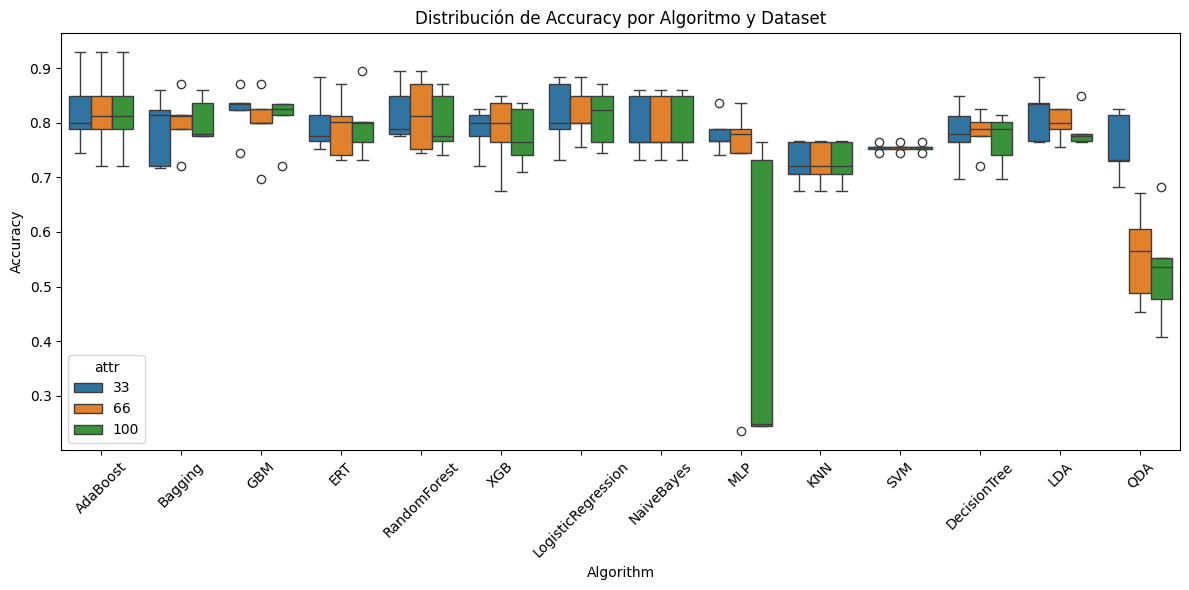

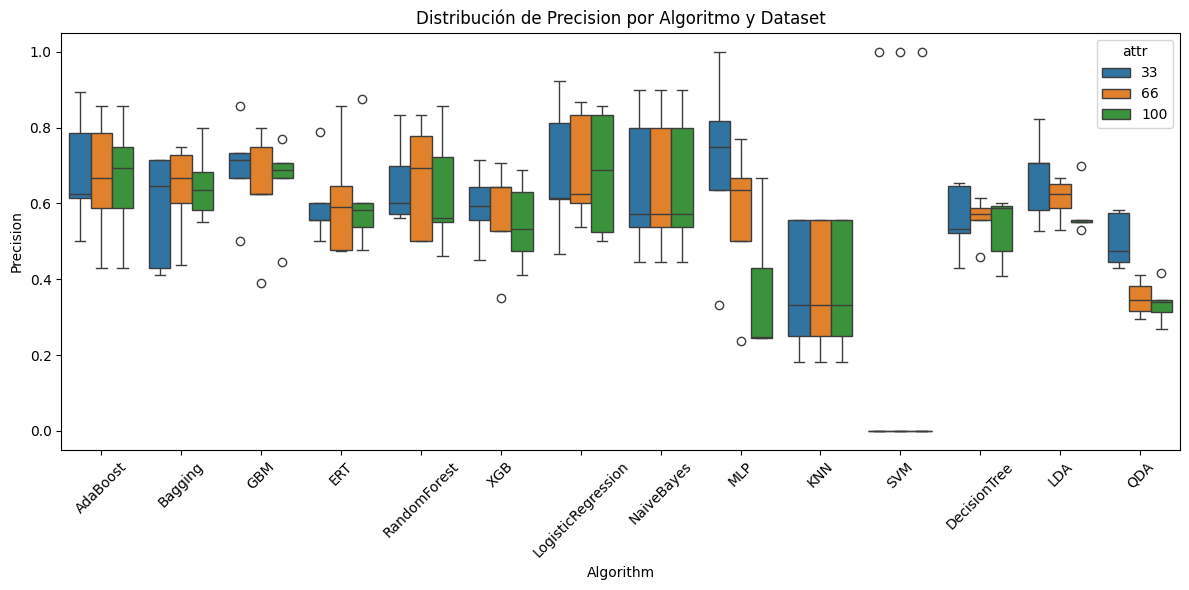

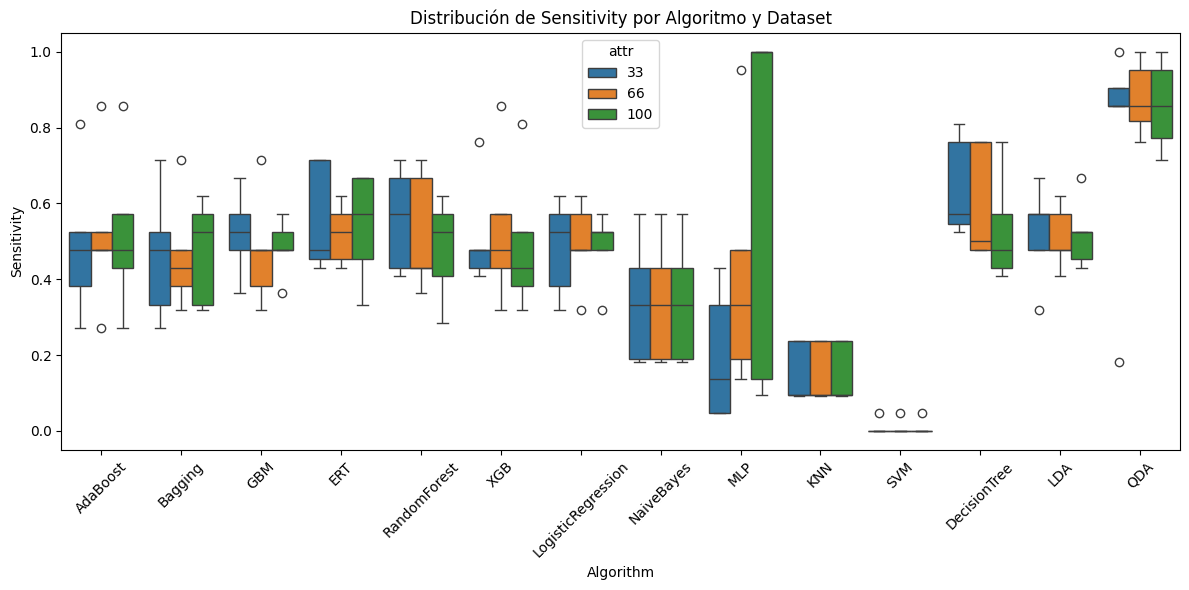

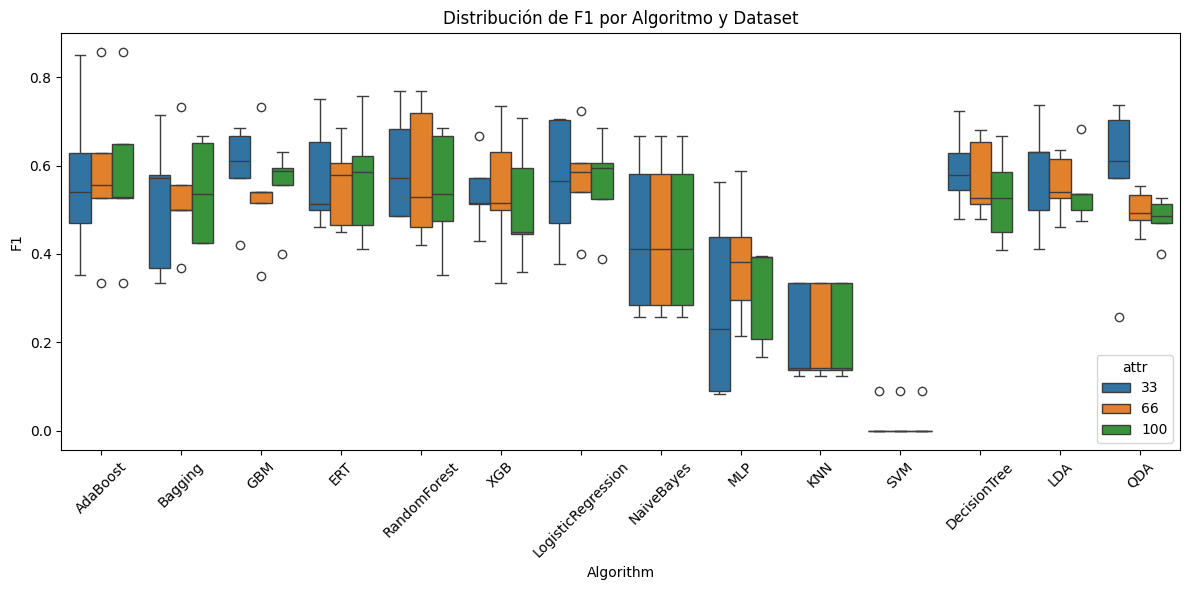

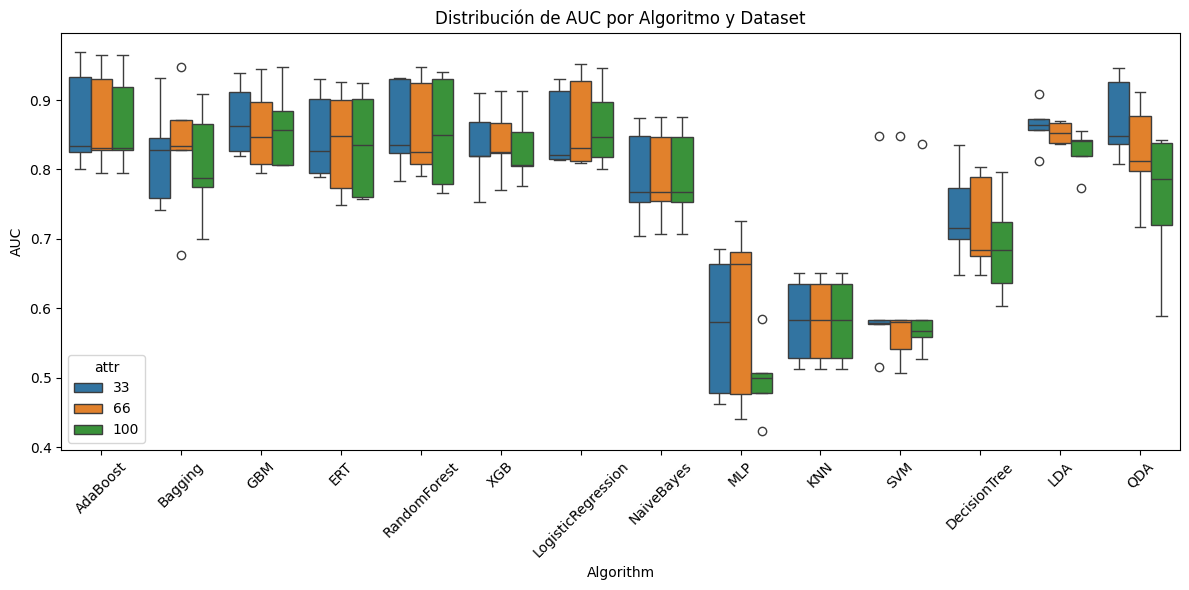

In [14]:
""" 
# Paso 10: Evaluación con conjuntos de datos distintos (33%, 66% y 100%)

ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

# Preparar datasets
df_33 = df_vis[top_33 + ['income']]
df_66 = df_vis[top_66 + ['income']]
df_100 = df_vis[top_100 + ['income']]

datasets = {'33': df_33, '66': df_66, '100': df_100}


results_all = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, dataset in datasets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    for model_label, model in models.items():
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)

            # 👇 usamos la función metricas() que ya calcula Accuracy, Precision, Recall, F1 y AUC
            result = metricas(model, model_label, X_train, X_valid, y_train, y_valid)
            result['Fold'] = fold_idx
            result['attr'] = name  # 33, 66 o 100
            results_all.append(result)

# Consolidar en DataFrame
df_results_all = pd.DataFrame(results_all)

print(df_results_all.head())

""" 

# ============================
# Paso 10: Evaluación con 33%, 66% y 100% de atributos
# ============================

ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

# Preparar datasets
df_33 = df_vis[top_33 + ['income']]
df_66 = df_vis[top_66 + ['income']]
df_100 = df_vis[top_100 + ['income']]

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

# Definir métricas
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Validación cruzada
for name, dataset in datasets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    for model_label, model in models.items():
        scores = cross_validate(model, X, y, cv=5, scoring=scoring)

        for i in range(len(scores['test_accuracy'])):
            results_all.append({
                "Algorithm": model_label,
                "attr": name,
                "Fold": i+1,
                "Accuracy": scores['test_accuracy'][i],
                "Precision": scores['test_precision'][i],
                "Sensitivity": scores['test_recall'][i],
                "F1": scores['test_f1'][i],
                "AUC": scores['test_roc_auc'][i]   # 👈 renombrado aquí
            })

# Convertir a DataFrame
df_results_all = pd.DataFrame(results_all)

print("✅ df_results_all creado con columnas estandarizadas:")
print(df_results_all.columns.tolist())
print(df_results_all.head())
"""
for metric in metrics:
    
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Algorithm', y='Sensitivity', hue='attr', data=df_results_all)
    plt.title("Distribución de Sensibilidad (Recall) por Algoritmo y Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
"""
metrics_to_plot = ["Accuracy", "Precision", "Sensitivity", "F1", "AUC"]

for metric in metrics_to_plot:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Algorithm', y=metric, hue='attr', data=df_results_all)
    plt.title(f"Distribución de {metric} por Algoritmo y Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    
   
   

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

✅ df_results_all creado con todas las métricas estandarizadas:
['Algorithm', 'attr', 'Fold', 'Accuracy', 'Precision', 'Sensitivity', 'F1', 'AUC']
  Algorithm attr  Fold  Accuracy  Precision  Sensitivity        F1       AUC
0  AdaBoost   33     1  0.930233   0.894737     0.809524  0.850000  0.969597
1  AdaBoost   33     2  0.848837   0.785714     0.523810  0.628571  0.932967
2  AdaBoost   33     3  0.744186   0.500000     0.272727  0.352941  0.800071
3  AdaBoost   33     4  0.800000   0.625000     0.476190  0.540541  0.824777
4  AdaBoost   33     5  0.788235   0.615385     0.380952  0.470588  0.834449


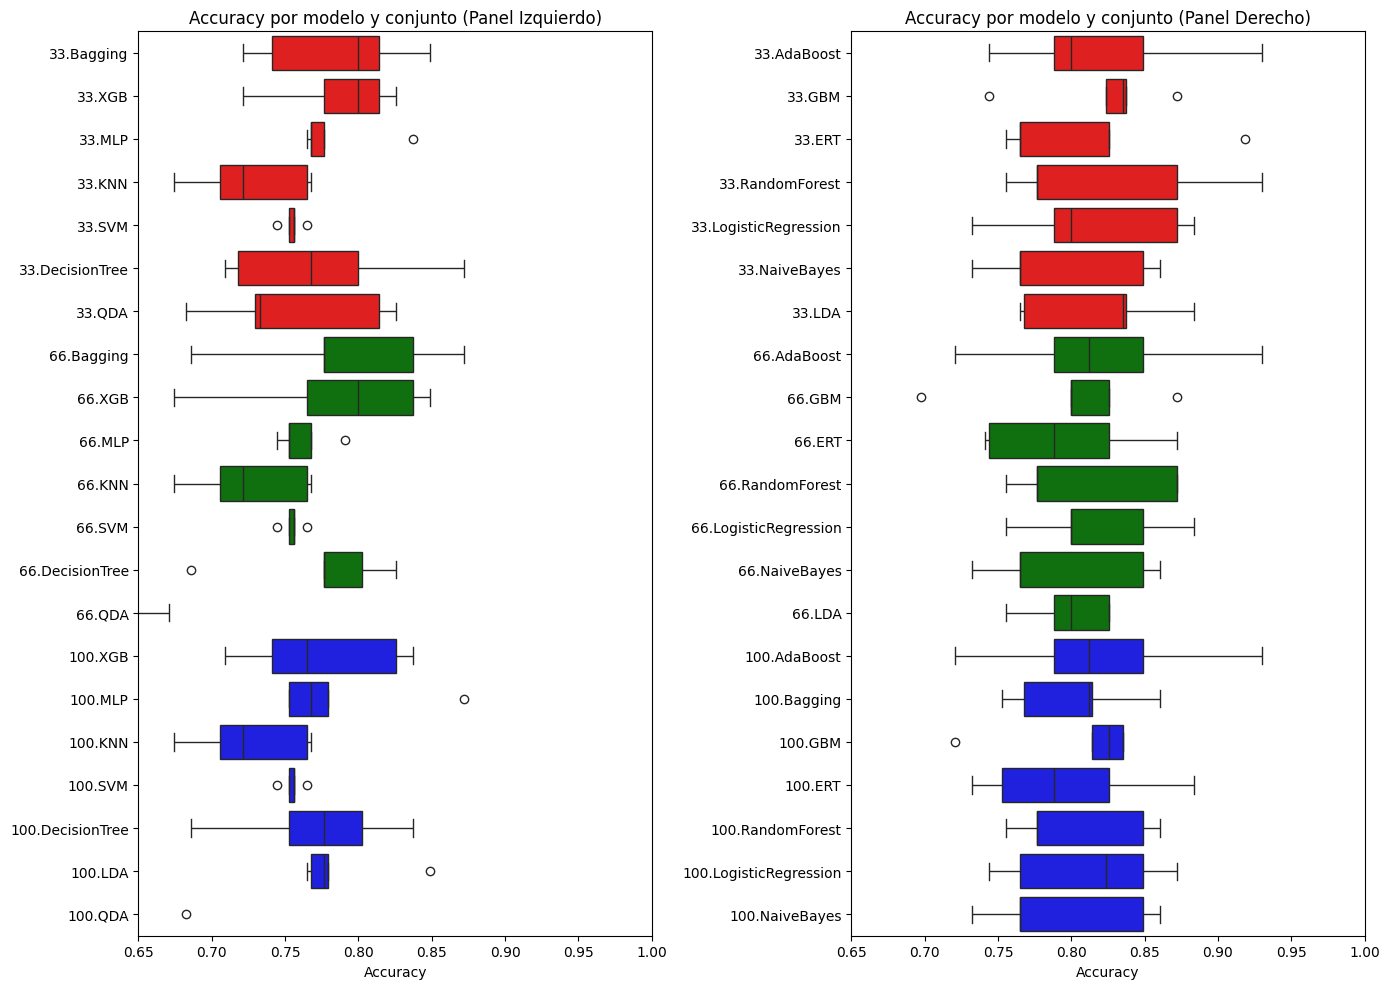

In [15]:

import matplotlib.gridspec as gridspec
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización tipo boxplot para Accuracy
from sklearn.model_selection import cross_validate

""" 
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización tipo boxplot
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['target'] = y

df_33 = df_vis[top_33 + ['target']]
df_66 = df_vis[top_66 + ['target']]
df_100 = df_vis[top_100 + ['target']]

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

# 🔹 Usamos cross-validation para tener varios valores y no solo uno
scoring = {'accuracy': 'accuracy'}

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1)
    y = dataset['target']

    for model_label, model in models.items():
        scores = cross_validate(model, X, y, cv=5, scoring=scoring)

        for acc in scores['test_accuracy']:
            results_all.append({
                "Algorithm": model_label,
                "Accuracy": acc,
                "attr": name
            })

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)

""" 

ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

# Preparar datasets
df_33 = df_vis[top_33 + ['income']]
df_66 = df_vis[top_66 + ['income']]
df_100 = df_vis[top_100 + ['income']]

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

# Definir métricas
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Validación cruzada
for name, dataset in datasets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    for model_label, model in models.items():
        scores = cross_validate(model, X, y, cv=5, scoring=scoring)

        for i in range(len(scores['test_accuracy'])):
            results_all.append({
                "Algorithm": model_label,
                "attr": name,
                "Fold": i+1,
                "Accuracy": scores.get('test_accuracy', [np.nan])[i],
                "Precision": scores.get('test_precision', [np.nan])[i],
                "Sensitivity": scores.get('test_recall', [np.nan])[i],
                "F1": scores.get('test_f1', [np.nan])[i],
                "AUC": scores.get('test_roc_auc', [np.nan])[i]   # 👈 garantizado como AUC
            })

# Convertir a DataFrame
df_results_all = pd.DataFrame(results_all)
print("✅ df_results_all creado con todas las métricas estandarizadas:")
print(df_results_all.columns.tolist())
print(df_results_all.head())

# Crear clave de algoritmo + atributo para agrupamiento visual
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# 📊 Gráfico tipo panel (izquierdo y derecho)
metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()



In [16]:
print(df_results_all.columns.tolist())
print(df_results_all.head())



['Algorithm', 'attr', 'Fold', 'Accuracy', 'Precision', 'Sensitivity', 'F1', 'AUC', 'Label', 'Color']
  Algorithm attr  Fold  Accuracy  Precision  Sensitivity        F1       AUC  \
0  AdaBoost   33     1  0.930233   0.894737     0.809524  0.850000  0.969597   
1  AdaBoost   33     2  0.848837   0.785714     0.523810  0.628571  0.932967   
2  AdaBoost   33     3  0.744186   0.500000     0.272727  0.352941  0.800071   
3  AdaBoost   33     4  0.800000   0.625000     0.476190  0.540541  0.824777   
4  AdaBoost   33     5  0.788235   0.615385     0.380952  0.470588  0.834449   

         Label Color  
0  33.AdaBoost   red  
1  33.AdaBoost   red  
2  33.AdaBoost   red  
3  33.AdaBoost   red  
4  33.AdaBoost   red  


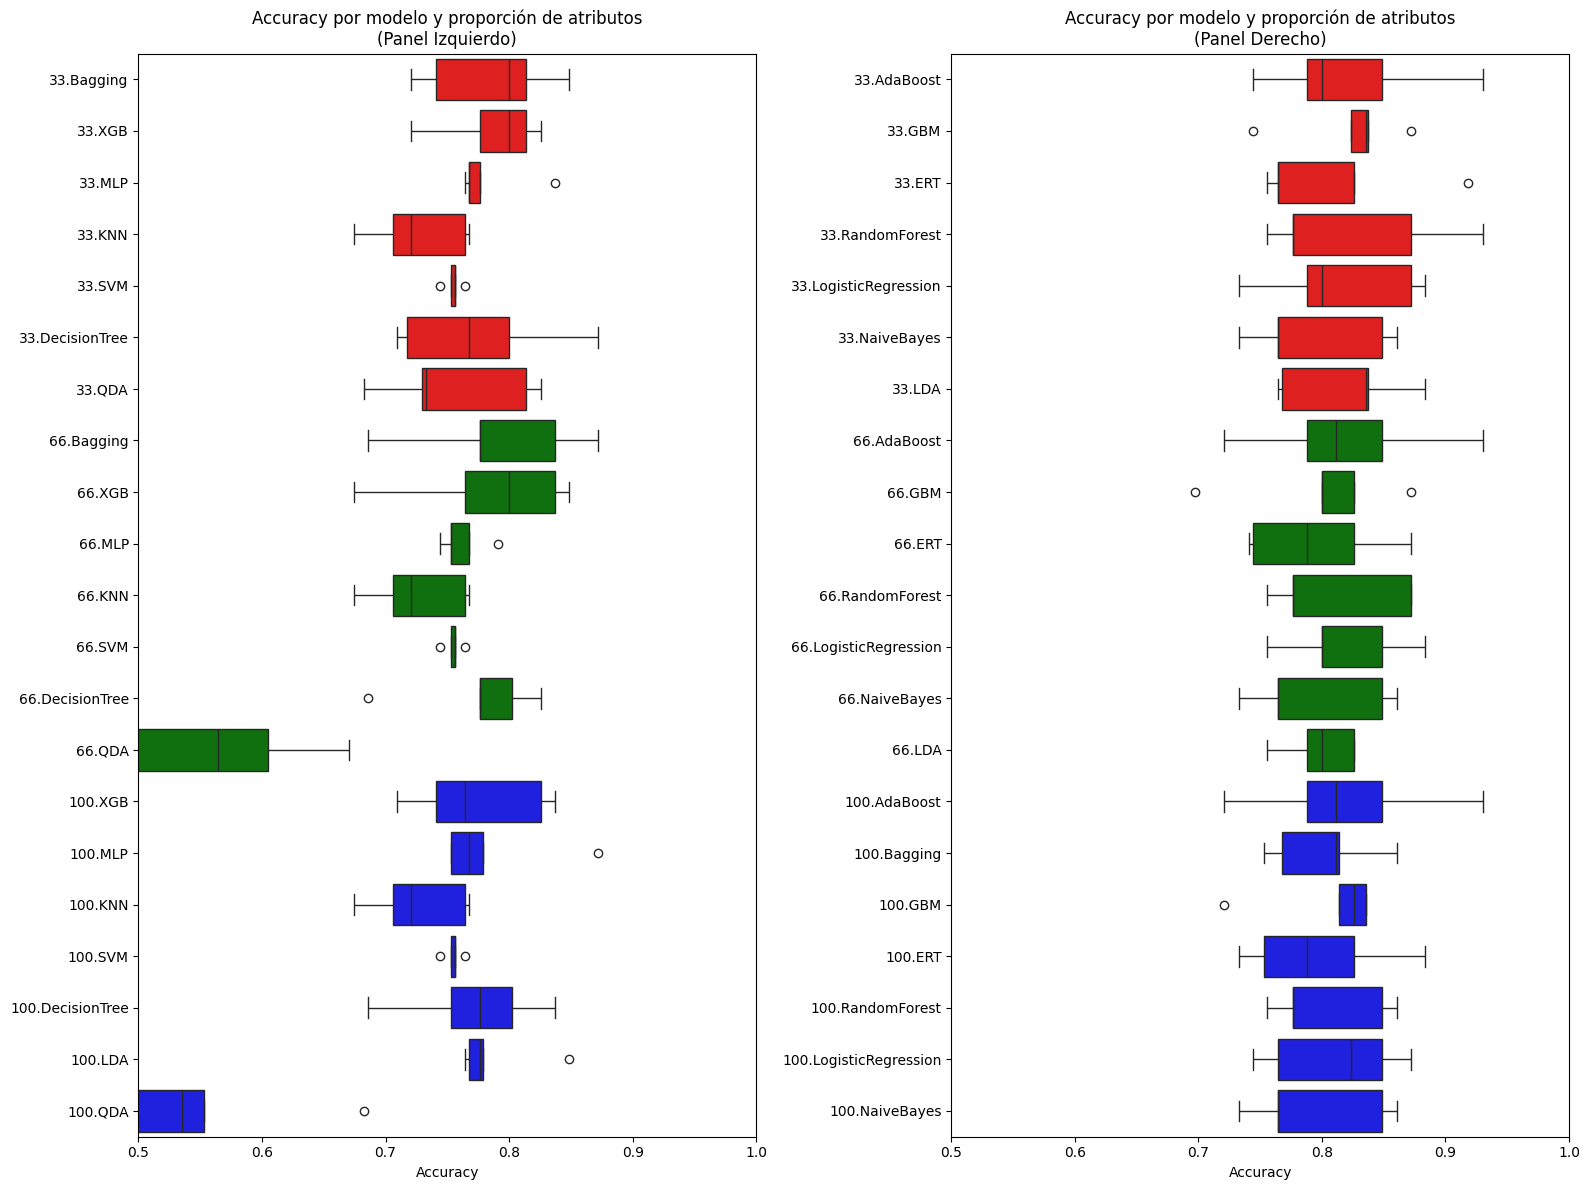

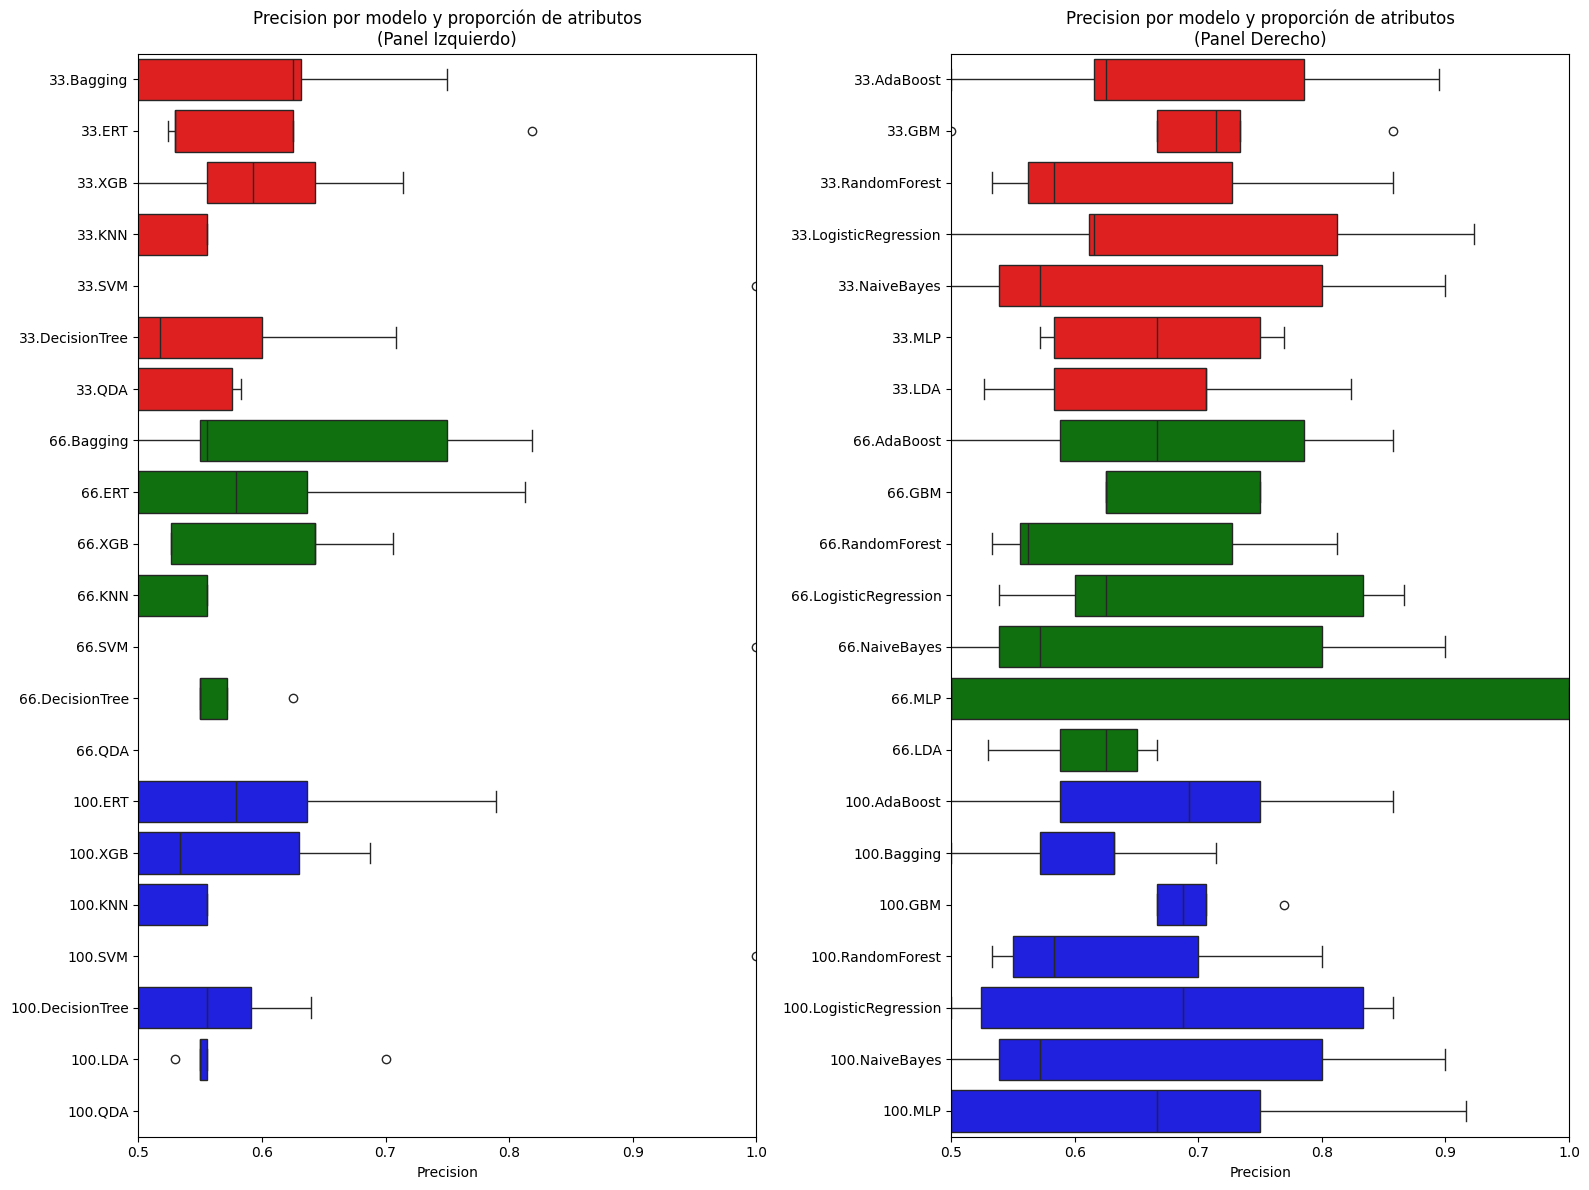

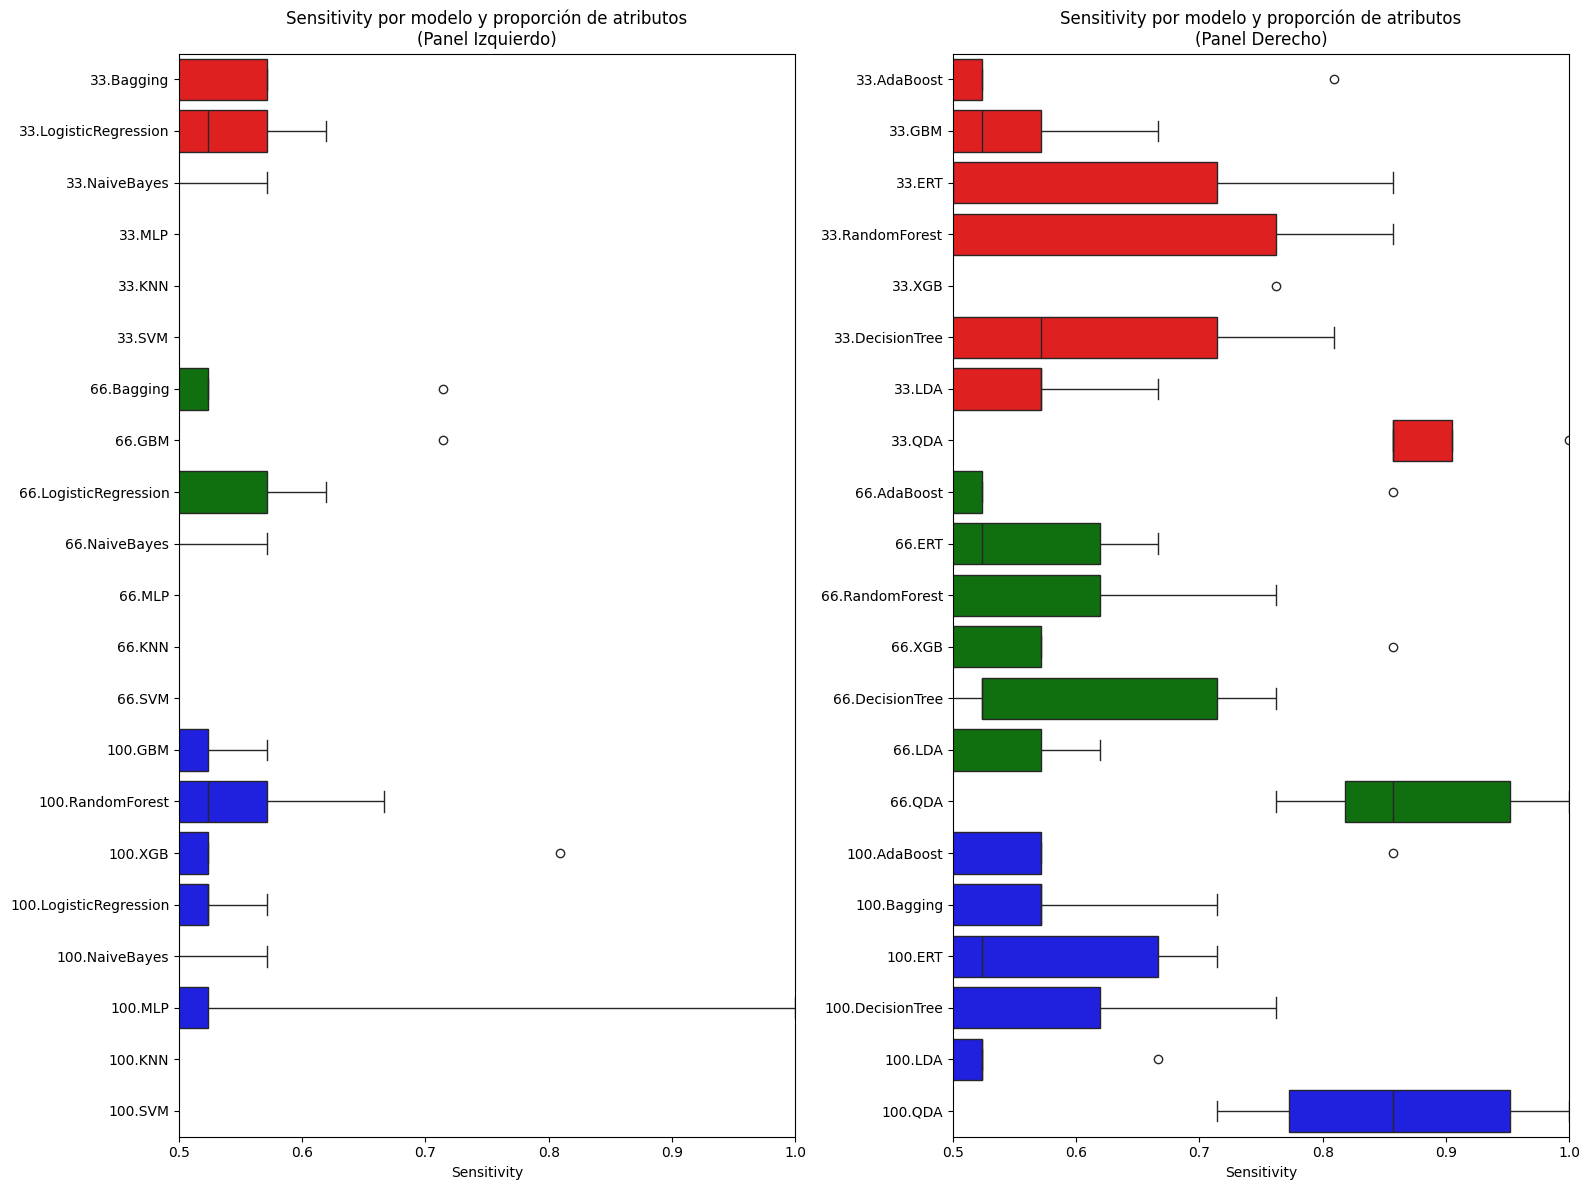

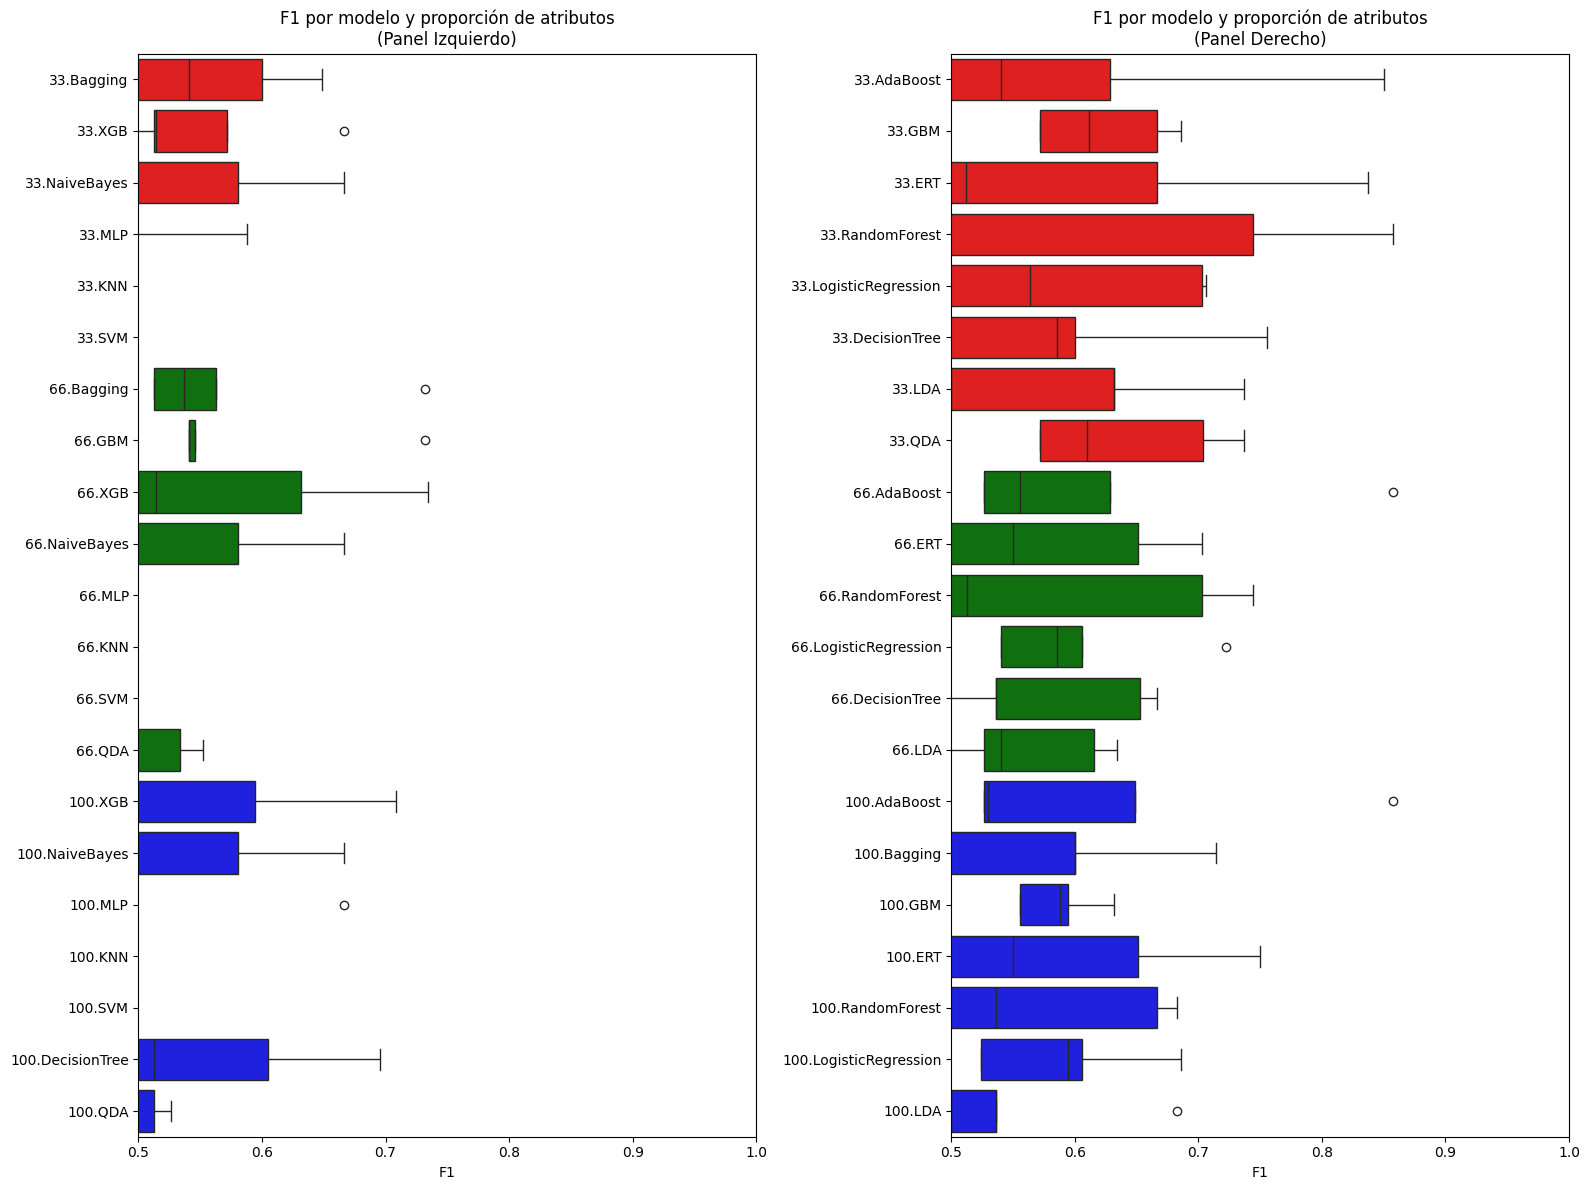

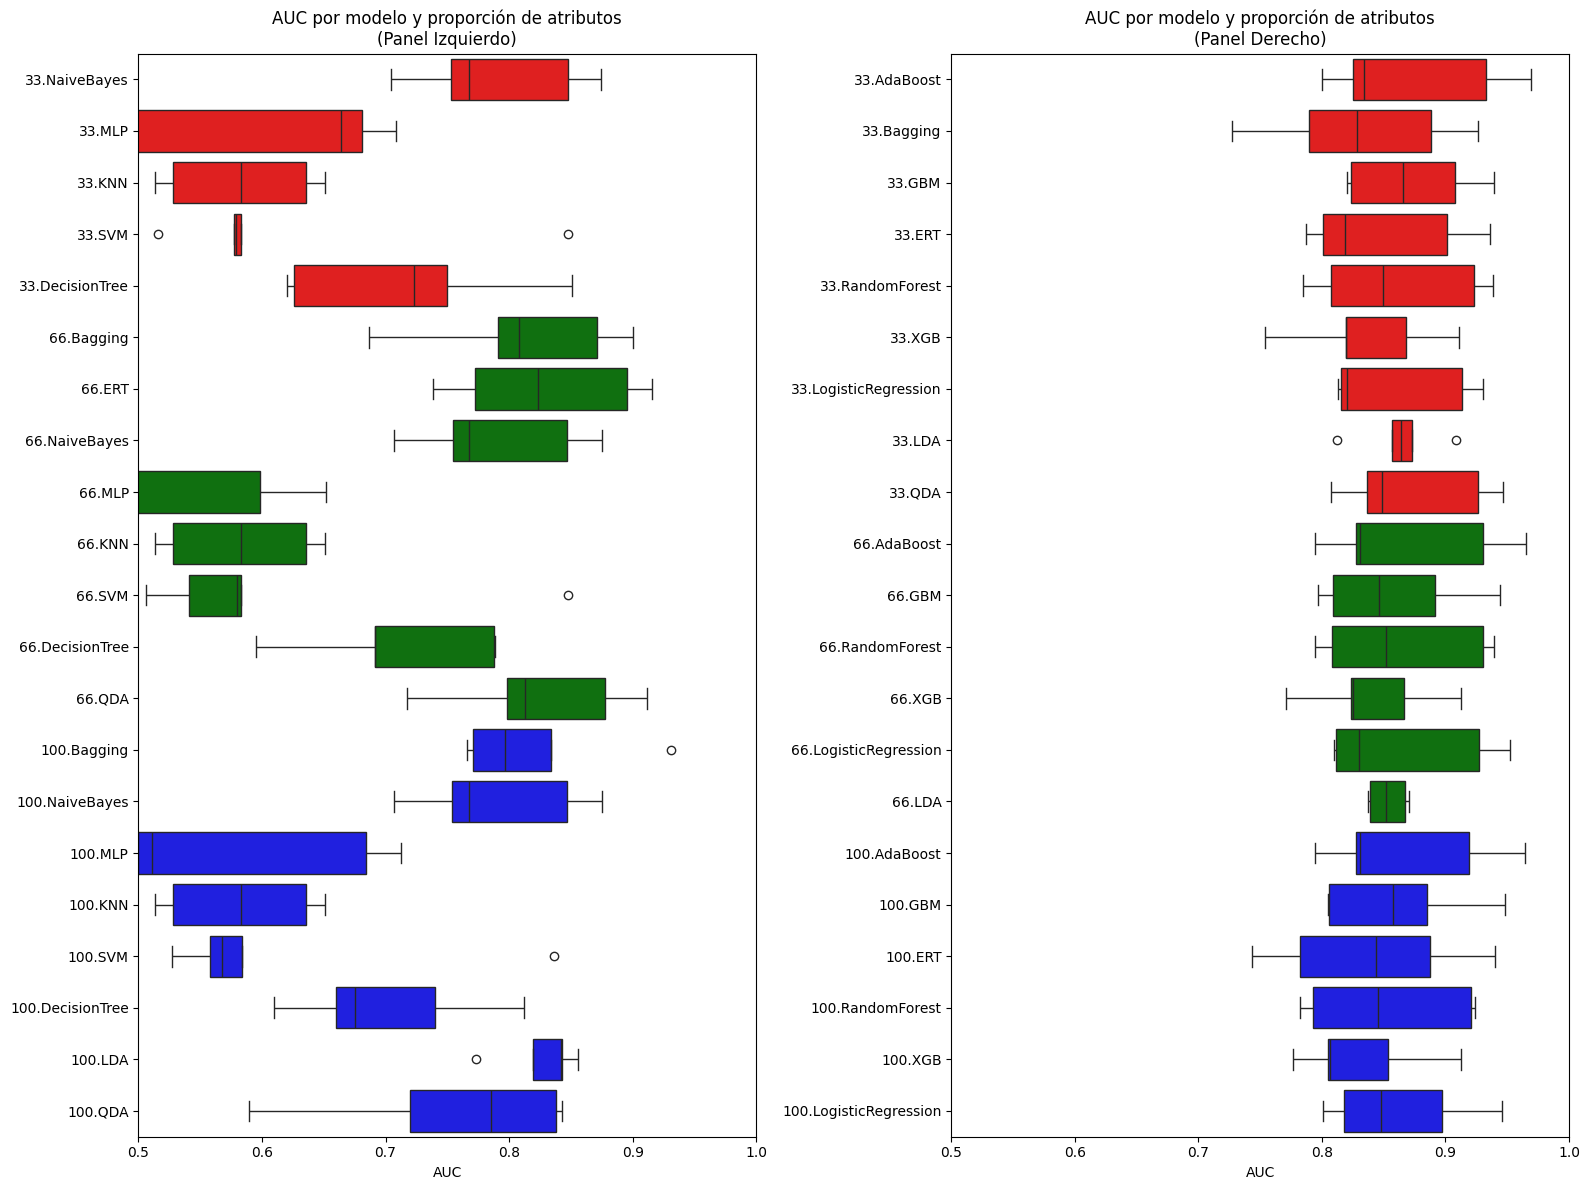

In [17]:
# 📊 Visualización tipo panel para todas las métricas
metrics_to_plot = ["Accuracy", "Precision", "Sensitivity", "F1", "AUC"]

for metric in metrics_to_plot:
    # Ordenar modelos según el promedio de la métrica
    sorted_labels = (
        df_results_all.groupby(['attr','Algorithm'])[metric]
        .mean()
        .sort_values()
        .index
    )

    # Crear figura con dos paneles
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

    # Convertir el MultiIndex en etiquetas de texto (attr.Algorithm)
    sorted_labels_text = [f"{a}.{m}" for a, m in sorted_labels]

    half = len(sorted_labels_text) // 2

    for i, ax in enumerate(axs):
        labels = sorted_labels_text[half*i:half*(i+1)]
        subset = df_results_all.copy()
        subset['Label'] = subset['attr'] + '.' + subset['Algorithm']
        subset = subset[subset['Label'].isin(labels)]

        sns.boxplot(
            data=subset,
            y='Label',
            x=metric,
            hue='attr',
            orient='h',
            ax=ax,
            palette={'33': 'red', '66': 'green', '100': 'blue'}
        )

        ax.set_xlim(0.5, 1.0)  # rango genérico para métricas
        ax.set_xlabel(metric)
        ax.set_ylabel('')
        ax.set_title(
            f'{metric} por modelo y proporción de atributos\n'
            f'({"Panel Izquierdo" if i == 0 else "Panel Derecho"})'
        )
        ax.legend_.remove()

    plt.tight_layout()
    plt.show()

## Análisis de Curvas de Rashomon y Complejidad de Modelos en Adminsion

En esta sección se incorpora el análisis de **curvas de Rashomon**, 
la evaluación de la **complejidad del modelo**, y la representación de un **frente de Pareto** entre precisión y simplicidad del sistema.

El objetivo es observar si modelos más simples pueden alcanzar niveles similares de rendimiento y así facilitar la explicabilidad.


In [18]:
# Análisis de Curvas de Rashomon con Múltiples Conjuntos de Atributos

import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd

warnings.filterwarnings('ignore')

# Supuestos: variables disponibles
# X, y, ranking_df, models

# Definición de subconjuntos de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC    

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)
                if y_prob.shape[1] > 1:
                    from sklearn.preprocessing import label_binarize
                    y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                    auc = roc_auc_score(y_bin, y_prob, average='macro')
                else:
                    auc = roc_auc_score(y_valid_r, y_prob[:, 0])
            except:
                auc = roc_auc_score(y_valid_r, y_pred)

            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            elif hasattr(model, 'estimators_'):
                complexity = sum([est.tree_.node_count for est in model.estimators_])
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)    
rashomon_df

,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon
0,top33,AdaBoost,0.699046,0.117228,50.000000,0.810994,1,False
1,top33,Bagging,0.668926,0.029945,10.000000,0.810994,1,False
2,top33,GBM,0.660141,0.162841,100.000000,0.810994,1,False
3,top33,ERT,0.621235,0.139489,100.000000,0.810994,1,False
4,top33,RandomForest,0.662902,0.169322,100.000000,0.810994,1,False
5,top33,XGB,0.743474,0.092590,NaN,0.810994,1,False
6,top33,LogisticRegression,0.707831,0.227190,26.000000,0.810994,1,False
7,top33,NaiveBayes,0.615713,0.002191,0.002191,0.810994,1,False
8,top33,MLP,0.562500,0.020561,100.000000,0.810994,1,False
9,top33,KNN,0.525853,0.002006,0.002006,0.810994,1,False


In [19]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon,ParetoFront
5,top33,XGB,0.743474,0.092590,NaN,0.810994,1,False,True
7,top33,NaiveBayes,0.615713,0.002191,0.002191,0.810994,1,False,True
9,top33,KNN,0.525853,0.002006,0.002006,0.810994,1,False,True
13,top33,QDA,0.810994,0.003150,0.003150,0.810994,1,True,True
15,top66,Bagging,0.662902,0.030141,10.000000,0.716616,1,False,True
19,top66,XGB,0.701807,0.106981,NaN,0.716616,1,False,True
20,top66,LogisticRegression,0.716616,0.230932,52.000000,0.716616,1,True,True
21,top66,NaiveBayes,0.615713,0.001008,0.001008,0.716616,1,False,True
25,top66,DecisionTree,0.689257,0.004033,14.000000,0.716616,1,False,True
27,top66,QDA,0.640060,0.008492,0.008492,0.716616,1,False,True


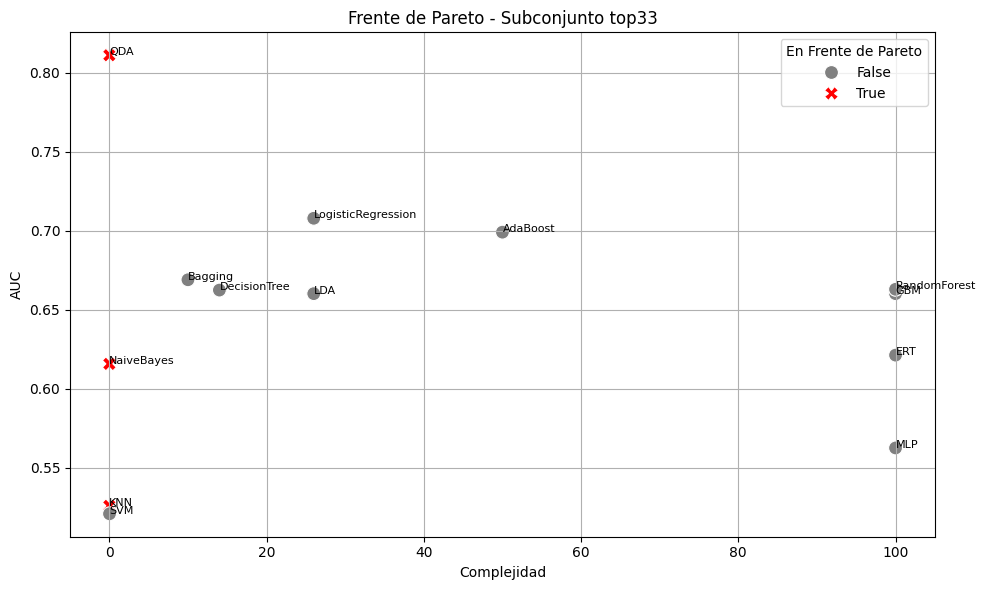

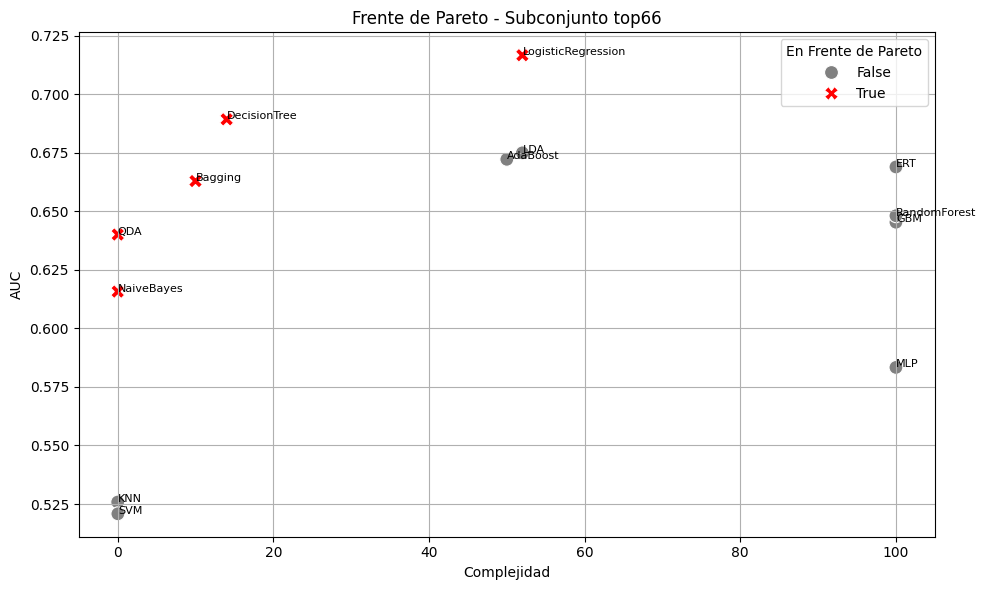

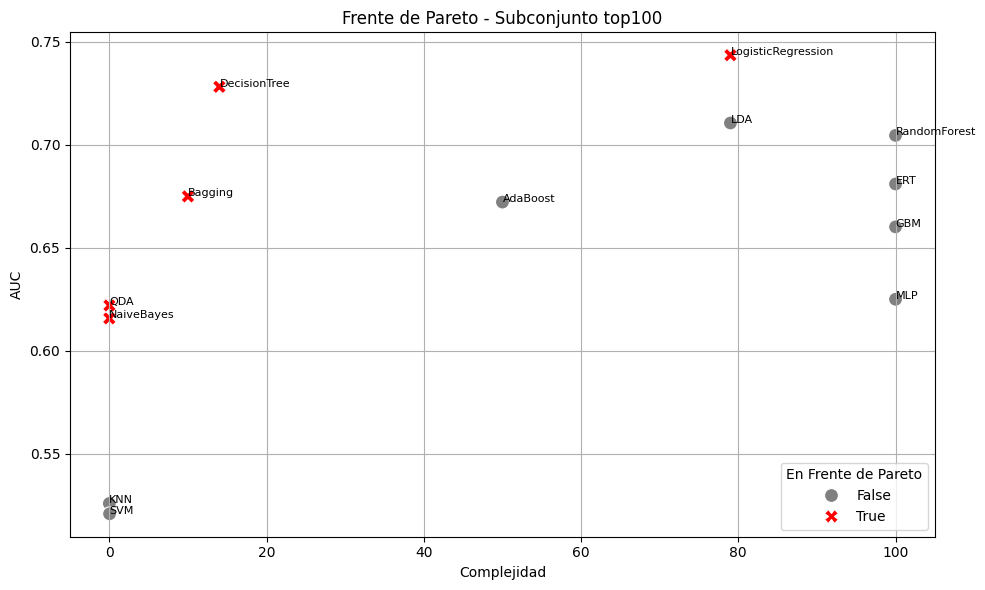

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📊 Analizando subconjunto 'top33' con 26 features...
   ✅ AdaBoost                  AUC=0.8978 | Time=0.10s | Comp=50
   ✅ Bagging                   AUC=0.8298 | Time=0.03s | Comp=10
   ✅ GBM                       AUC=0.8554 | Time=0.17s | Comp=100
   ✅ ERT                       AUC=0.8213 | Time=0.14s | Comp=100
   ✅ RandomForest              AUC=0.8562 | Time=0.18s | Comp=100
   ✅ XGB                       AUC=0.8549 | Time=0.09s | Comp=None
   ✅ LogisticRegression        AUC=0.8695 | Time=0.23s | Comp=26
   ✅ NaiveBayes                AUC=0.8138 | Time=0.00s | Comp=0.002785205841064453
   ✅ MLP                       AUC=0.5863 | Time=0.03s | Comp=100
   ✅ KNN                       AUC=0.6182 | Time=0.00s | Comp=0.002319812774658203
   ✅ SVM                       AUC=0.7184 | Time=0.02s | Comp=0.02220916748046875
   ✅ DecisionTree              AUC=0.7161 | Time=0.00s | Comp=119
   ✅ LDA                       AUC=0.8017 | Time=0.00s | Comp=26
   ✅ QDA                       AUC=0.8454 

,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon
0,top33,AdaBoost,0.897841,0.102722,50.0,0.897841,1,True
1,top33,Bagging,0.829819,0.033093,10.0,0.897841,1,False
2,top33,GBM,0.855422,0.165020,100.0,0.897841,1,False
3,top33,ERT,0.821285,0.141849,100.0,0.897841,1,False
4,top33,RandomForest,0.856175,0.177532,100.0,0.897841,1,False


✅ Modelos del frente de Pareto exportados como 'rashomon_pareto_models.csv'


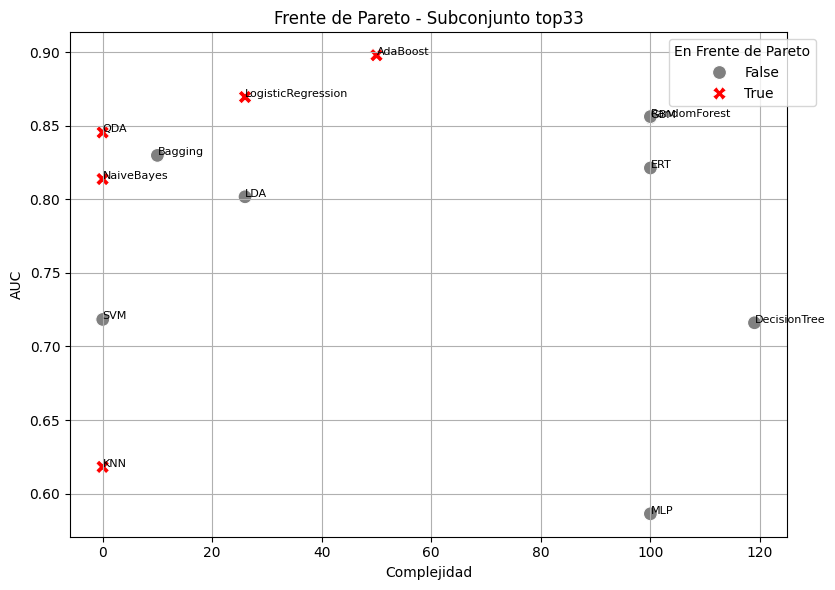

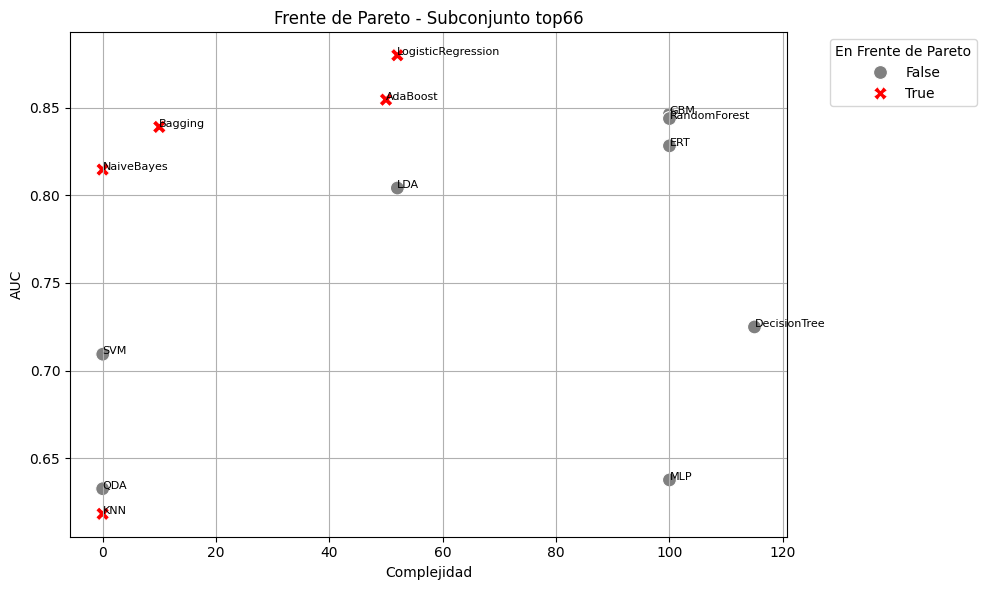

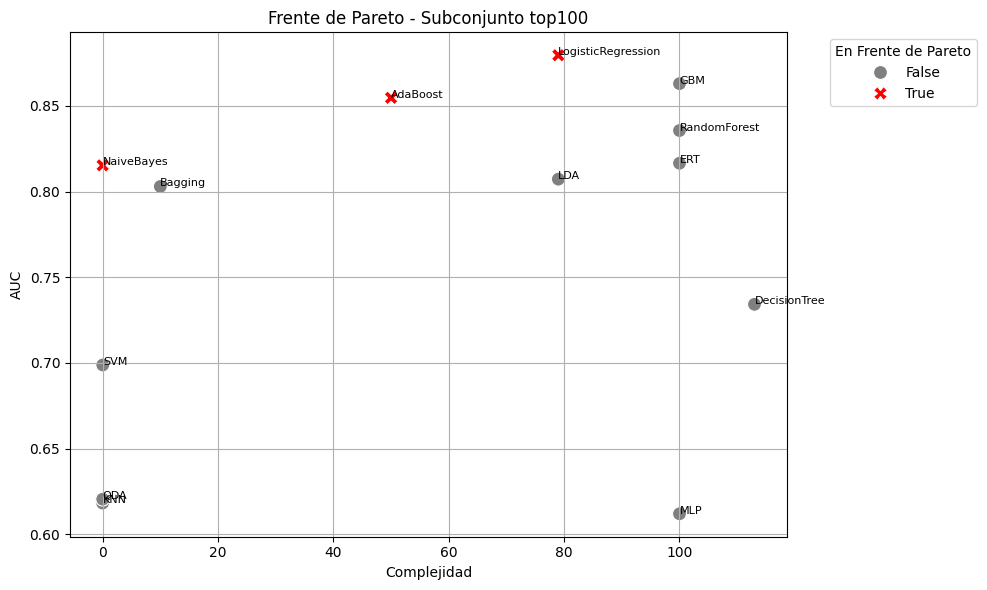

In [21]:
# ==========================================================
# 🔍 ANÁLISIS DE CURVAS DE RASHOMON Y FRENTES DE PARETO
# ==========================================================
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

warnings.filterwarnings('ignore')

# Supuestos: variables ya disponibles -> X, y, ranking_df, models
assert 'X' in locals(), "Variable X no encontrada"
assert 'y' in locals(), "Variable y no encontrada"
assert 'ranking_df' in locals(), "Variable ranking_df no encontrada"
assert 'models' in locals(), "Diccionario models no encontrado"

# ==========================================================
# 1️⃣ Definir subconjuntos de atributos
# ==========================================================
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

# ==========================================================
# 2️⃣ Evaluar cada subconjunto con todos los modelos
# ==========================================================
for subset_name, features in feature_sets.items():
    # Filtrar solo columnas válidas
    features = [f for f in features if f in X.columns]
    if not features:
        print(f"⚠️ Subconjunto {subset_name} sin columnas válidas en X. Se omite.")
        continue

    print(f"\n📊 Analizando subconjunto '{subset_name}' con {len(features)} features...")

    try:
        X_sub = X[features]
        X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(
            X_sub, y, test_size=0.25, random_state=42
        )
    except Exception as e:
        print(f"❌ Error preparando subconjunto {subset_name}: {e}")
        continue

    subset_scores = []
    best_auc = -np.inf

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)

            try:
                if hasattr(model, "predict_proba"):
                    y_prob = model.predict_proba(X_valid_r)
                    if y_prob.shape[1] == 2:
                        auc = roc_auc_score(y_valid_r, y_prob[:, 1])
                    else:
                        y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                        auc = roc_auc_score(y_bin, y_prob, average="macro")
                else:
                    auc = roc_auc_score(y_valid_r, y_pred)
            except Exception as e:
                print(f"⚠️ Error AUC en {model_label} ({subset_name}): {e}")
                continue

            best_auc = max(best_auc, auc)

            # Complejidad del modelo
            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = np.prod(model.coef_.shape)
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.node_count
            elif hasattr(model, 'estimators_'):
                complexity = sum(getattr(est.tree_, 'node_count', 0) for est in model.estimators_)
            else:
                complexity = train_time  # fallback

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })

            print(f"   ✅ {model_label:<25} AUC={auc:.4f} | Time={train_time:.2f}s | Comp={complexity}")

        except Exception as e:
            print(f"❌ Error con {model_label} en {subset_name}: {e}")

    if not subset_scores:
        print(f"⚠️ Ningún modelo válido en {subset_name}.")
        continue

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

# ==========================================================
# 3️⃣ Crear DataFrame con todos los resultados
# ==========================================================
rashomon_df = pd.DataFrame(rashomon_results)
print(f"\n✅ Resultados generados: {rashomon_df.shape[0]} filas, {rashomon_df['Subset'].nunique()} subconjuntos.")
display(rashomon_df.head())

# ==========================================================
# 4️⃣ Identificar modelos en el frente de Pareto
# ==========================================================
def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
if rashomon_df.empty:
    print("⚠️ rashomon_df está vacío; no se puede calcular el frente de Pareto.")
else:
    for subset in rashomon_df['Subset'].unique():
        df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
        if df_subset.empty:
            continue
        df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
        pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list, ignore_index=True) if pareto_df_list else pd.DataFrame()
if pareto_df.empty:
    print("⚠️ No se generaron frentes de Pareto.")
else:
    pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
    print("✅ Modelos del frente de Pareto exportados como 'rashomon_pareto_models.csv'")

# ==========================================================
# 5️⃣ Visualización de los frentes de Pareto por subconjunto
# ==========================================================
if not pareto_df.empty:
    for subset in pareto_df['Subset'].unique():
        data = pareto_df[pareto_df['Subset'] == subset]
        if data.empty:
            continue

        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='Complexity', y='AUC',
            hue='ParetoFront', style='ParetoFront',
            palette={True: 'red', False: 'gray'},
            data=data, s=100
        )
        for _, row in data.iterrows():
            plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

        plt.title(f'Frente de Pareto - Subconjunto {subset}')
        plt.xlabel('Complejidad')
        plt.ylabel('AUC')
        plt.legend(title='En Frente de Pareto', bbox_to_anchor=(1.05, 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No hay datos para graficar frentes de Pareto.")